# The following notebook demonstrates the procedure for calibrating a 3-parameter analytic model to a set of numerical simulations and evaluating the quality of the final model 

### The results within this notebook have been peer-reviewed and published in The Astrophysical Journal: Haynie, A. & Piro, A. L. "Estimating Ejecta Masses of Stripped-Envelope Supernovae Using Late-Time Light Curves". 2023, ApJ, 956, 98

In [1]:
#Load necessary libraries 
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import emcee
import corner
from scipy import stats
from scipy.stats import linregress
import scipy.optimize
np.set_printoptions(threshold=np.inf)
from sympy import Point, Line
from matplotlib.ticker import AutoMinorLocator

#astrophysical constants 
Msun = 1.989e33 #mass of sun in g
C = 0.05 #constant 
beta = 13.8 #constant
kappa_gamma = 0.03 #gamma ray opacity in cm^2/g
day = 86400 #seconds per day
t_Ni = 8.8 #nickel decay timescale in days 
t_Co = 111 #cobalt decay timescale in days 
c = 3e10 #speed of light in cm/s

## load and visualize the simulation data

In [2]:
#load best fit T0 values, velocities, and f-constants for each energy from other notebooks 
#and define various applicable masses 

%store -r 

T0 = np.hstack([T0_1e51,T0_1_5e51,T0_2e51,T0_2_5e51,T0_3e51,T0_3_5e51,T0_4e51])*86400

Mej = np.array([3.1084-1.42, 3.52575-1.44, 3.86765-1.42, 4.2302-1.38, 4.4833-1.45, 4.6111-1.46,
                4.969699-1.45, 5.31519-1.6, 5.61296-1.58, 6.2878-1.71, 6.6192-1.73])

M_inner = np.array([1.42, 1.44, 1.42, 1.38, 1.45, 1.46, 1.45, 1.6, 1.58, 1.71, 1.73])

En = np.array([1e51, 1.5e51, 2e51, 2.5e51, 3e51, 3.5e51, 4e51])

V = np.hstack([vel_1e51,vel_1_5e51,vel_2e51,vel_2_5e51,vel_3e51,vel_3_5e51,vel_4e51])

MZAMS = np.array([10.99, 12.09, 12.99, 13.96, 14.64, 15.00, 16.00, 17.00, 18.00, 19.98, 20.96])

f = (f_1 + f_1_5 + f_2 + f_2_5 + f_3 + f_3_5 + f_4)/7

In [3]:
#create arrays of mass and energy that correspond to the T0 value array to be able to fit over full parameter space

M = np.hstack([Mej, Mej, Mej, Mej, Mej, Mej, Mej])
E = np.array([En[0], En[0], En[0], En[0], En[0], En[0], En[0], En[0], En[0], En[0], En[0],
              En[1], En[1], En[1], En[1], En[1], En[1], En[1], En[1], En[1], En[1], En[1],  
              En[2], En[2], En[2], En[2], En[2], En[2], En[2], En[2], En[2], En[2], En[2],
              En[3], En[3], En[3], En[3], En[3], En[3], En[3], En[3], En[3], En[3], En[3],
              En[4], En[4], En[4], En[4], En[4], En[4], En[4], En[4], En[4], En[4], En[4],
              En[5], En[5], En[5], En[5], En[5], En[5], En[5], En[5], En[5], En[5], En[5],
              En[6], En[6], En[6], En[6], En[6], En[6], En[6], En[6], En[6], En[6], En[6]])

#define colors to represent each energy
color = ['b', 'r', 'g', 'm', 'c', 'k', 'orange']

(1.5, 5.133660000000001)

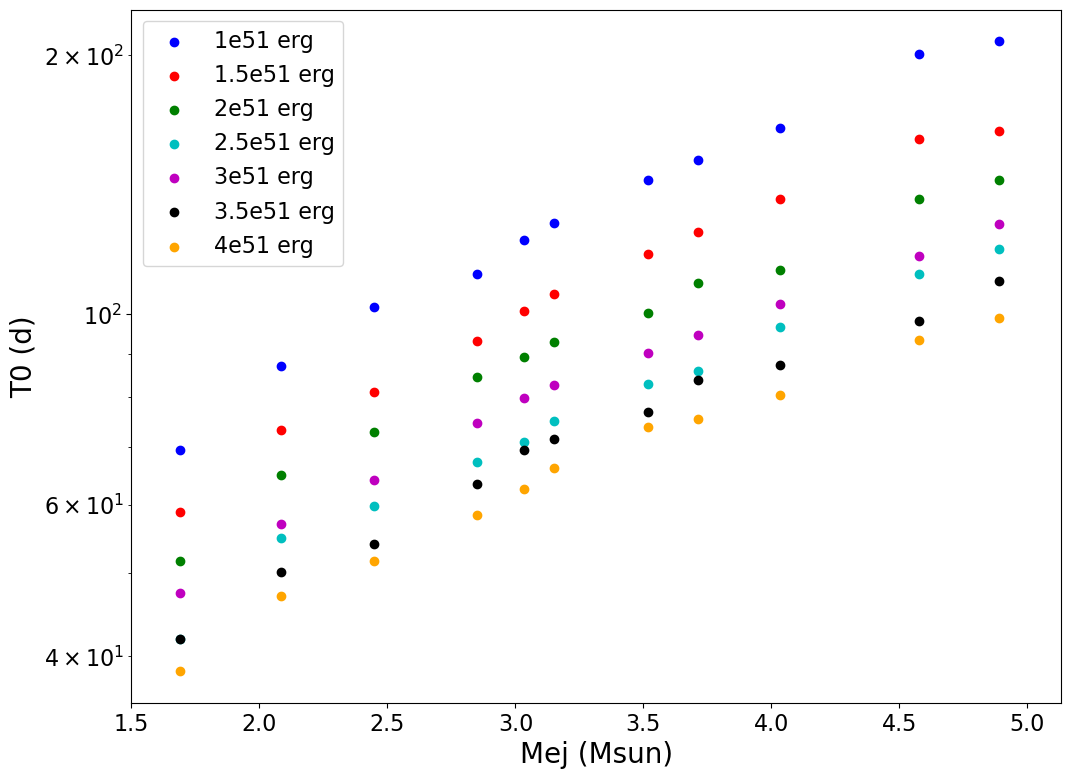

In [4]:
plt.figure(figsize=(12,9))
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

#plot best fit T0 vs ejecta Mass for each energy
for i in range(0,7):
    plt.plot(M[i*11:(i*11)+11], T0[i*11:(i*11)+11]/86400, c=color[i], marker='o', ls='')

#create color coded legend
a = np.zeros(3)
plt.scatter(a, a, c='b', label = '1e51 erg')
plt.scatter(a, a, c='r', label = '1.5e51 erg')
plt.scatter(a, a, c='g', label = '2e51 erg')
plt.scatter(a, a, c='c', label = '2.5e51 erg')
plt.scatter(a, a, c='m', label = '3e51 erg')
plt.scatter(a, a, c='k', label = '3.5e51 erg')
plt.scatter(a, a, c='orange', label = '4e51 erg')
plt.legend(fontsize=16)

    
plt.xlabel('Mej (Msun)', fontsize=20)
plt.ylabel('T0 (d)', fontsize=20)
plt.yscale('log')
plt.xlim(1.5)

(1.5, 5.133660000000001)

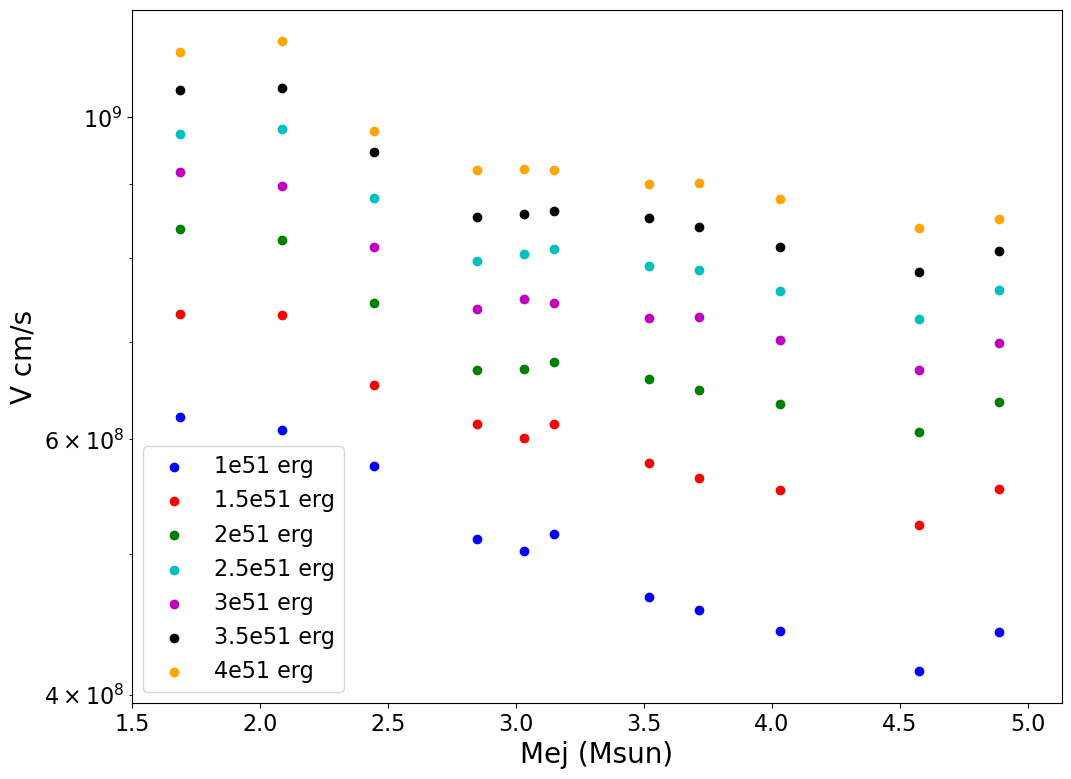

In [5]:
plt.figure(figsize=(12,9))
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

#plot photospheric velocity at the time of peak vs ejecta Mass for each energy
for i in range(0,7):
    plt.plot(M[i*11:(i*11)+11], V[i*11:(i*11)+11], c=color[i], marker='o', ls='')

#create color coded legend 
a = np.zeros(3)
plt.scatter(a, a, c='b', label = '1e51 erg')
plt.scatter(a, a, c='r', label = '1.5e51 erg')
plt.scatter(a, a, c='g', label = '2e51 erg')
plt.scatter(a, a, c='c', label = '2.5e51 erg')
plt.scatter(a, a, c='m', label = '3e51 erg')
plt.scatter(a, a, c='k', label = '3.5e51 erg')
plt.scatter(a, a, c='orange', label = '4e51 erg')
plt.legend(fontsize=16)
    
plt.xlabel('Mej (Msun)', fontsize=20)
plt.ylabel('V cm/s', fontsize=20)
plt.yscale('log')
plt.xlim(1.5)

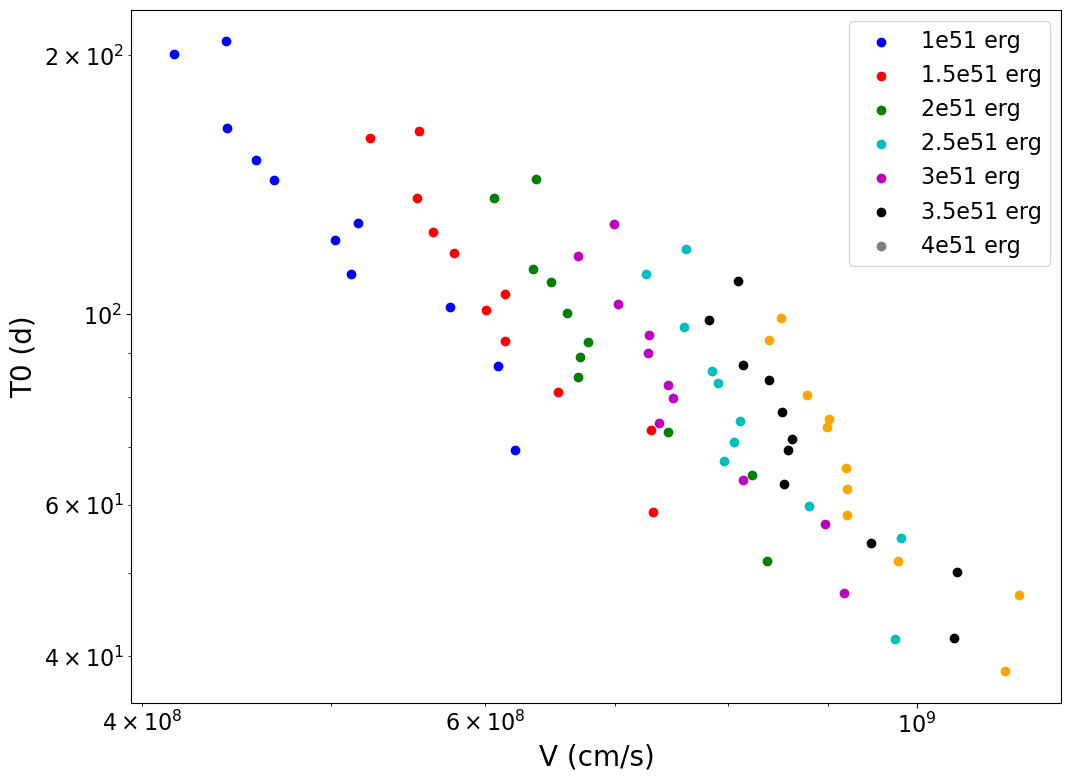

In [6]:
plt.figure(figsize=(12,9))
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

#plot best fit T0 vs photospheric velocity for each energy
for i in range(0,7):
    plt.plot(V[i*11:(i*11)+11], T0[i*11:(i*11)+11]/day, c=color[i], marker='o', ls='')
    
#create color coded legend
a = np.zeros(3)
plt.scatter(a, a, c='b', label = '1e51 erg')
plt.scatter(a, a, c='r', label = '1.5e51 erg')
plt.scatter(a, a, c='g', label = '2e51 erg')
plt.scatter(a, a, c='c', label = '2.5e51 erg')
plt.scatter(a, a, c='m', label = '3e51 erg')
plt.scatter(a, a, c='k', label = '3.5e51 erg')
plt.scatter(a, a, c='gray', label = '4e51 erg')
plt.legend(fontsize=16)
    
plt.xlabel('V (cm/s)', fontsize=20)
plt.ylabel('T0 (d)', fontsize=20)
plt.xscale('log')
plt.yscale('log')

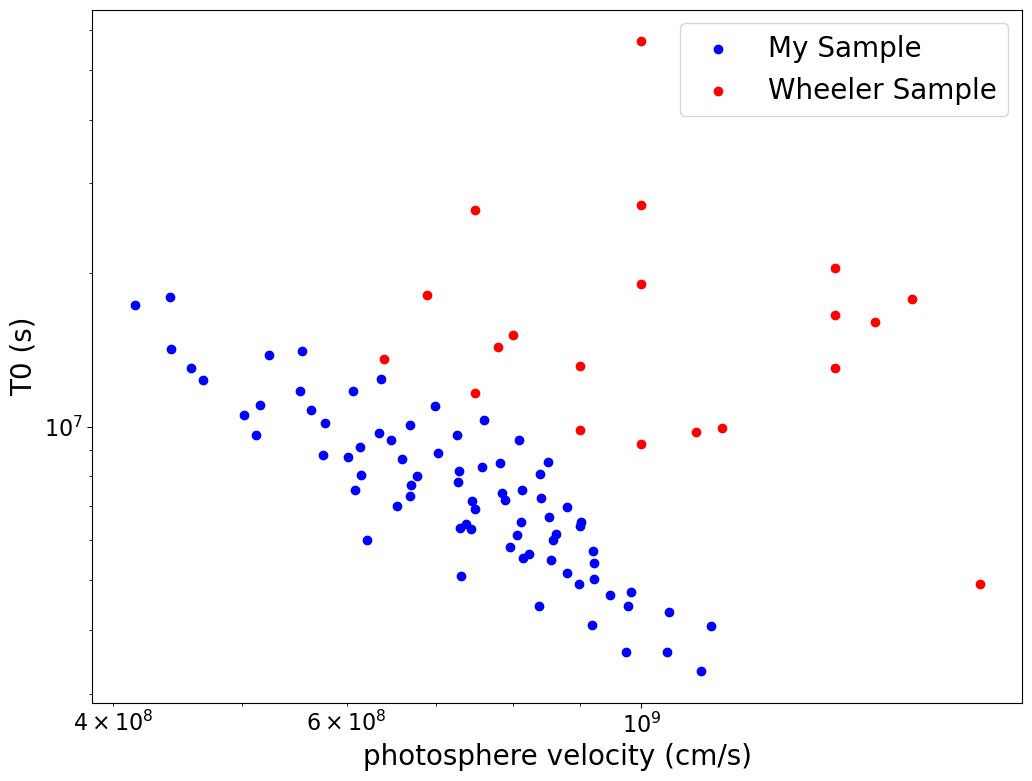

In [7]:
#load data from Wheeler et al. 2015 
wT0 = np.array([166, 151, 660, 113, 135, 115, 152, 192, 220, 186,
                237, 206, 114, 157, 107, 175, 57, 315, 308, 210])
wV = np.array([0.78, 1.4, 1.0, 1.1, 0.75, 1.15, 0.9, 1.4, 1.0, 1.5,
               1.4, 1.6, 0.9, 0.64, 1.0, 0.8, 1.8, 1.0, 0.75, 0.69])

#compare my results to that of the Wheeler 2015 paper
plt.figure(figsize=(12,9))
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
plt.scatter(V, T0, c='b', label='My Sample')
plt.scatter(wV*1e9, wT0*86400, c='r', label='Wheeler Sample')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('photosphere velocity (cm/s)', fontsize=20)
plt.ylabel('T0 (s)', fontsize=20)
plt.legend(fontsize=20)

Text(0.5, 0, '$M_{\\rm ZAMS}\\,(M_{\\odot})$')

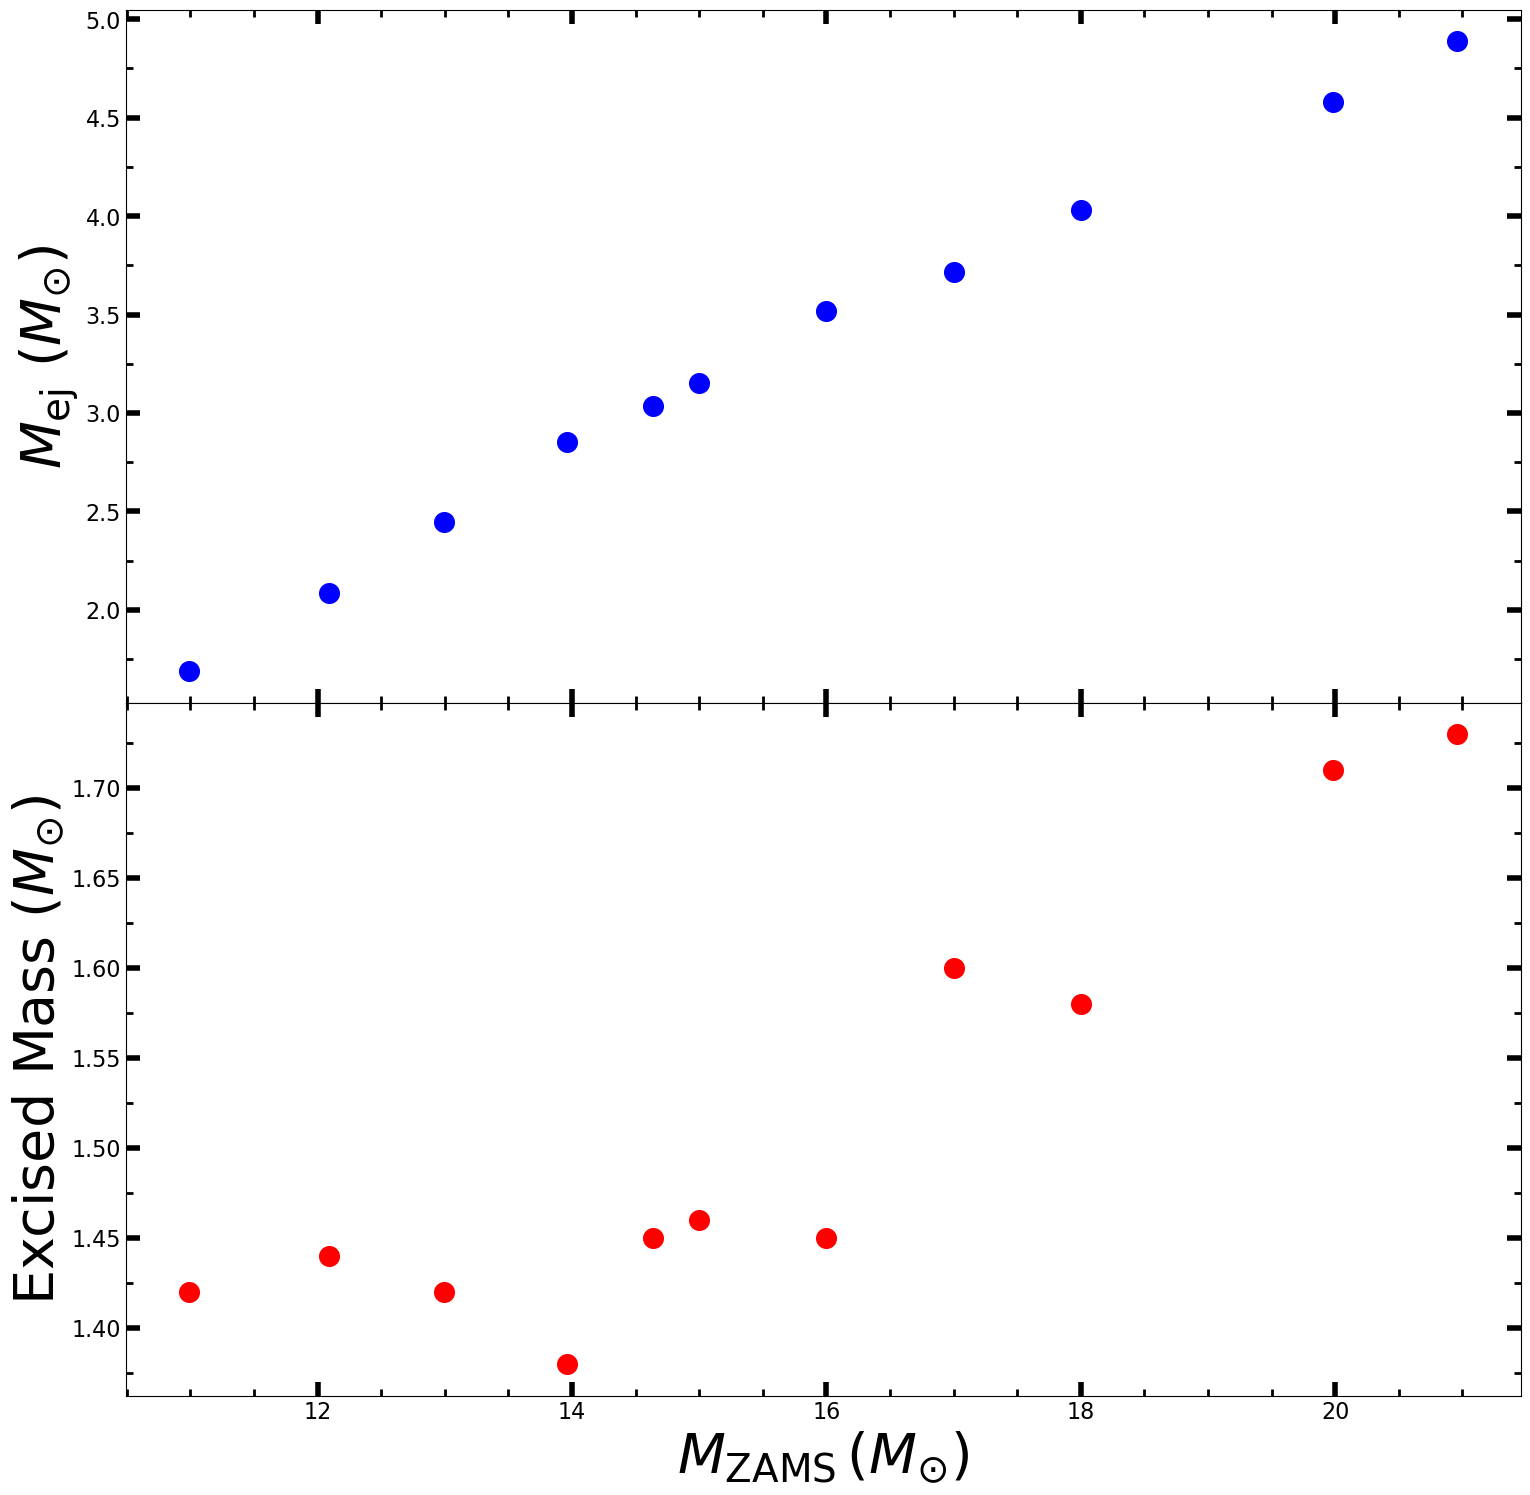

In [8]:
#make 2 subplots for paper Figure comparing ejecta mass and excised mass vs ZAMS mass 
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18,18))
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30

#set up minor axes ticks
ax1.minorticks_on()
ax2.minorticks_on()
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
#define ticks style 
ax1.tick_params(axis = 'both', which = 'major', direction='in',length=10, width=4, top = True, right = True)
ax2.tick_params(axis = 'both', which = 'major',direction='in',length=10, width=4, top = True, right = True)
ax1.tick_params(axis = 'both', which = 'minor', direction='in',length=5, width=2, top = True, right = True)
ax2.tick_params(axis = 'both', which = 'minor',direction='in',length=5, width=2, top = True, right = True)

ax1.scatter(MZAMS, Mej, s=200, c='b')
ax2.scatter(MZAMS, M_inner, s=200, c='r')
plt.subplots_adjust(hspace=0)

ax1.set_ylabel(r'$M_{\rm ej}\ (M_{\odot})$', fontsize=40)
ax2.set_ylabel(r'Excised Mass $(M_{\odot})$', fontsize=40)
ax2.set_xlabel(r'$M_{\rm ZAMS}\,(M_{\odot})$', fontsize=40)

#save figure for paper
#plt.savefig('Masses.eps', bbox_inches = "tight", pad_inches=0.2, transparent = False,
#           facecolor='white')

## Define and optimize funtions for MCMC process

In [9]:
#define funtions necessary for 3-parameter model fitting 

def get_index(tstart, tdata):
    j = 1
    for i in range(0,len(tdata)):
        if tstart < 0:
            if tstart > tdata[i]:
                j = i
        elif tstart > 0:
            if tstart > tdata[i]:
                j = i      
    return j

def mod_test(A, B, C, Mass, vel):
    logT0 = A + B*np.log10(Mass*Msun) + C*np.log10(vel)
    return np.power(10,logT0)

#3 parameter model to fit 
def model(A, B, C):
    logT0 = A + B*np.log10(M*Msun) + C*np.log10(V)
    return logT0

#ejecta mass estimate given best fit parameters
def get_Mej(T_0, vel, a, b, c):
    A = np.power(10,a)
    calc = T_0 * np.power(vel, -1*c)/A
    return np.power(calc, 1/b)

#objective function - chisq fit 
def obj(P):
    a,b,c = P
    logT0_calc = model(a,b,c)
    logT0_obs = np.log10(T0)
    sigma = f*logT0_obs
    chisq = ((logT0_obs - logT0_calc)**2/sigma**2).sum()
    return chisq

#log probability
def logprob(P):
    return -0.5*obj(P)

#variance of a variable
def var(x, xbar, N):
    v = np.power(x-xbar,2).sum()
    return v/N

#covariance between two variables
def cov(x, xbar, y, ybar, N):
    c = ((x-xbar)*(y-ybar)).sum()
    return c/(N-1)

#pearson's correlation coefficient
def pearson(x, xbar, y, ybar):
    n = ((x-xbar)*(y-ybar)).sum()
    m = np.power(x-xbar, 2).sum()
    p = np.power(y-ybar, 2).sum()
    q = np.power(m, 0.5)
    r = np.power(p, 0.5)
    s = n/(q*r)
    return s

In [10]:
#set up initial guess for best fit values of A, B, and C
guess = [-4, 0.5, -1]
print(obj(guess))

2092523.1307545674


In [11]:
#find best fit values of A, B, and C by minimizing the objective function (smallest chi squared value)
result = scipy.optimize.minimize(obj, guess)
print(result)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 114.74859328089418
        x: [-4.337e+00  6.080e-01 -1.054e+00]
      nit: 3
      jac: [-4.239e-02  1.252e+00  3.522e-01]
 hess_inv: [[ 2.105e-01 -4.983e-03 -4.748e-03]
            [-4.983e-03  1.275e-04  7.634e-05]
            [-4.748e-03  7.634e-05  2.446e-04]]
     nfev: 196
     njev: 46


In [12]:
#save best fit values as variables 
a_fit = result.x[0]
b_fit = result.x[1]
c_fit = result.x[2]

#print chi squared and log probability of best fit values
print(obj([a_fit, b_fit, c_fit]))
print(logprob([a_fit, b_fit, c_fit]))

114.74859328089418
-57.37429664044709


(1.5, 5.133660000000001)

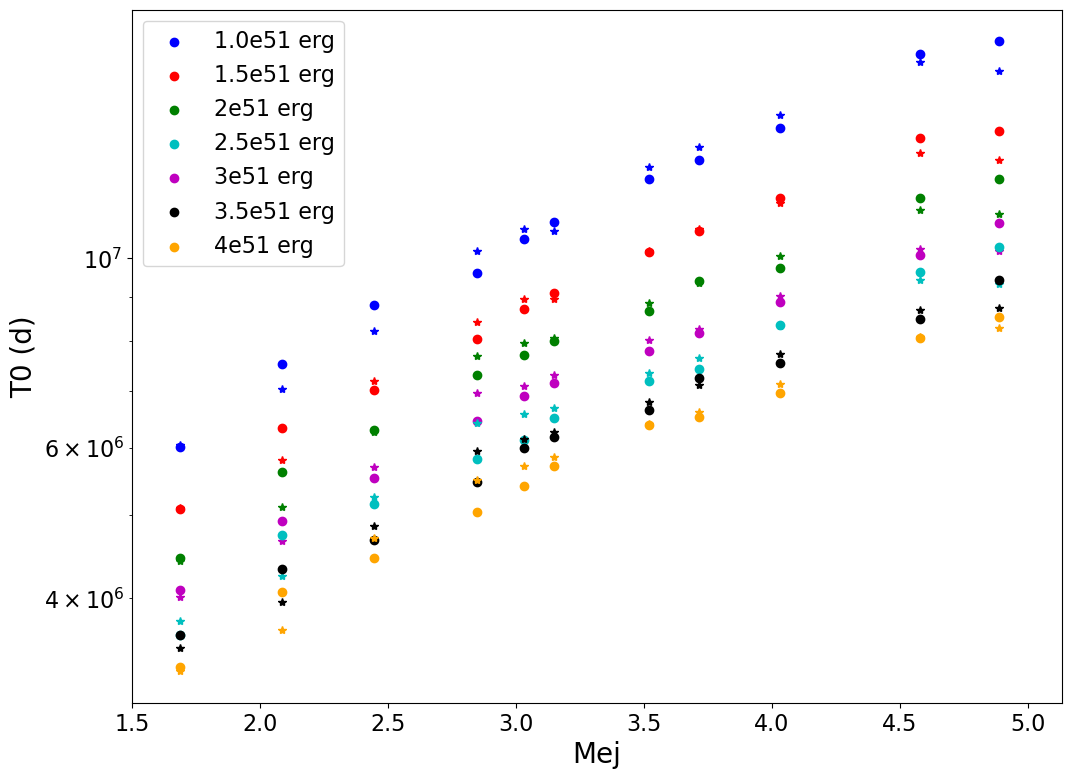

In [13]:
plt.figure(figsize=(12,9))
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16


#plot best fit T0 values vs ejecta mass alongside the calculated T0 values 
#given the best fit A,B, and C parameters vs ejecta mass

for i in range(0,7):
    plt.plot(M[i*11:(i*11)+11], T0[i*11:(i*11)+11], c=color[i], marker='o', ls='')
    plt.plot(M[i*11:(i*11)+11], mod_test(a_fit, b_fit, c_fit,M[i*11:(i*11)+11], V[i*11:(i*11)+11])
             , c=color[i], marker='*', ls='')
    
a = np.zeros(3)
plt.scatter(a, a, c='b', label = '1.0e51 erg')
plt.scatter(a, a, c='r', label = '1.5e51 erg')
plt.scatter(a, a, c='g', label = '2e51 erg')
plt.scatter(a, a, c='c', label = '2.5e51 erg')
plt.scatter(a, a, c='m', label = '3e51 erg')
plt.scatter(a, a, c='k', label = '3.5e51 erg')
plt.scatter(a, a, c='orange', label = '4e51 erg')
plt.legend(fontsize=16)
    
plt.xlabel('Mej', fontsize=20)
plt.ylabel('T0 (d)', fontsize=20)
plt.yscale('log')
plt.xlim(1.5)

## Use MCMC to calibrate model to numerical simulations with a defined error

In [14]:
#set up MCMC random walk and burn in 100 steps after initial placement
#this step is necessary for understanding the error associated with the best fit values solved for above

ndim = 3 #corresponding to 3 parameters to fit 
nwalkers = 99 #total number of walkers

p0 = np.random.rand(nwalkers, ndim) # initial guess for each of the walkers
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob)
state = sampler.run_mcmc(p0, 100)

In [15]:
#reset the number of steps to 0 and begin full MCMC for 10000 steps
sampler.reset()
sampler.run_mcmc(state, 10000);

In [16]:
#store the chain for each parameter 
Tsamples = sampler.get_chain(flat=True)
print(Tsamples.shape)

%store Tsamples 

(990000, 3)
Stored 'Tsamples' (ndarray)


In [17]:
#define average and standard deviation, and 68% confidence interval for each chain 

mean1, sigma1 = np.mean(Tsamples[:, 0]), np.std(Tsamples[:, 0])
conf_int_1 = stats.norm.interval(0.68, loc=mean1, scale=sigma1)

mean2, sigma2 = np.mean(Tsamples[:, 1]), np.std(Tsamples[:, 1])
conf_int_2 = stats.norm.interval(0.68, loc=mean2, scale=sigma2)

mean3, sigma3 = np.mean(Tsamples[:, 2]), np.std(Tsamples[:, 2])
conf_int_3 = stats.norm.interval(0.68, loc=mean3, scale=sigma3)

In [18]:
print("3 parameter a fit: ", mean1, conf_int_1)
print("3 parameter b fit: ", mean2, conf_int_2)
print("3 parameter c fit: ", mean3, conf_int_3)

print('\n Variance of:')
print("a:", var(Tsamples[:,0], mean1, len(Tsamples[:,0])))
print("b:", var(Tsamples[:,1], mean2, len(Tsamples[:,1])))
print("c:", var(Tsamples[:,2], mean3, len(Tsamples[:,2])))

print('\n Covariance of:')
print("a and b:", cov(Tsamples[:,0], mean1, Tsamples[:,1], mean2, len(Tsamples[:,0])))
print("a and c:", cov(Tsamples[:,0], mean1, Tsamples[:,2], mean3, len(Tsamples[:,0])))
print("b and c:", cov(Tsamples[:,1], mean2, Tsamples[:,2], mean3, len(Tsamples[:,0])))

print('\n Pearsons Correlation Coefficient:')
print("a and b:", pearson(Tsamples[:,0], mean1, Tsamples[:,1], mean2))
print("a and c:", pearson(Tsamples[:,0], mean1, Tsamples[:,2], mean3))
print("b and c:", pearson(Tsamples[:,1], mean2, Tsamples[:,2], mean3))

3 parameter a fit:  -4.336744009012469 (-4.9845495935580875, -3.688938424466851)
3 parameter b fit:  0.6080443947642811 (0.592107876793466, 0.6239809127350961)
3 parameter c fit:  -1.0538368631008235 (-1.0758431513082245, -1.0318305748934224)

 Variance of:
a: 0.4243425536448666
b: 0.00025681127319906923
c: 0.0004896895127665831

 Covariance of:
a and b: -0.010048400461553515
a and c: -0.00956713962486454
b and c: 0.00015465797090575696

 Pearsons Correlation Coefficient:
a and b: -0.9625674273134465
a and c: -0.6636864928568946
b and c: 0.43611841566683224


In [19]:
#create copies of each chain as their own array to be able to manipulate 

Tsamples1 = np.zeros(len(Tsamples[:,0]))
Tsamples2 = np.zeros(len(Tsamples[:,1]))
Tsamples3 = np.zeros(len(Tsamples[:,2]))

for i in range(0, len(Tsamples)):
        
    Tsamples1[i] = Tsamples[i, 0]
    Tsamples2[i] = Tsamples[i, 1]
    Tsamples3[i] = Tsamples[i, 2]
    
print('done')

done


In [20]:
#sort each new array
Tsamples1.sort()
Tsamples2.sort()
Tsamples3.sort()

In [21]:
#define indicies of the edges of the 68% confidence interval for each parameter 

start1 = get_index(conf_int_1[0], Tsamples1)
end1 = get_index(conf_int_1[1], Tsamples1)

start2 = get_index(conf_int_2[0], Tsamples2)
end2 = get_index(conf_int_2[1], Tsamples2)

start3 = get_index(conf_int_3[0], Tsamples3)
end3 = get_index(conf_int_3[1], Tsamples3)

Text(0.5, 1.0, '3 Parameter Fit')

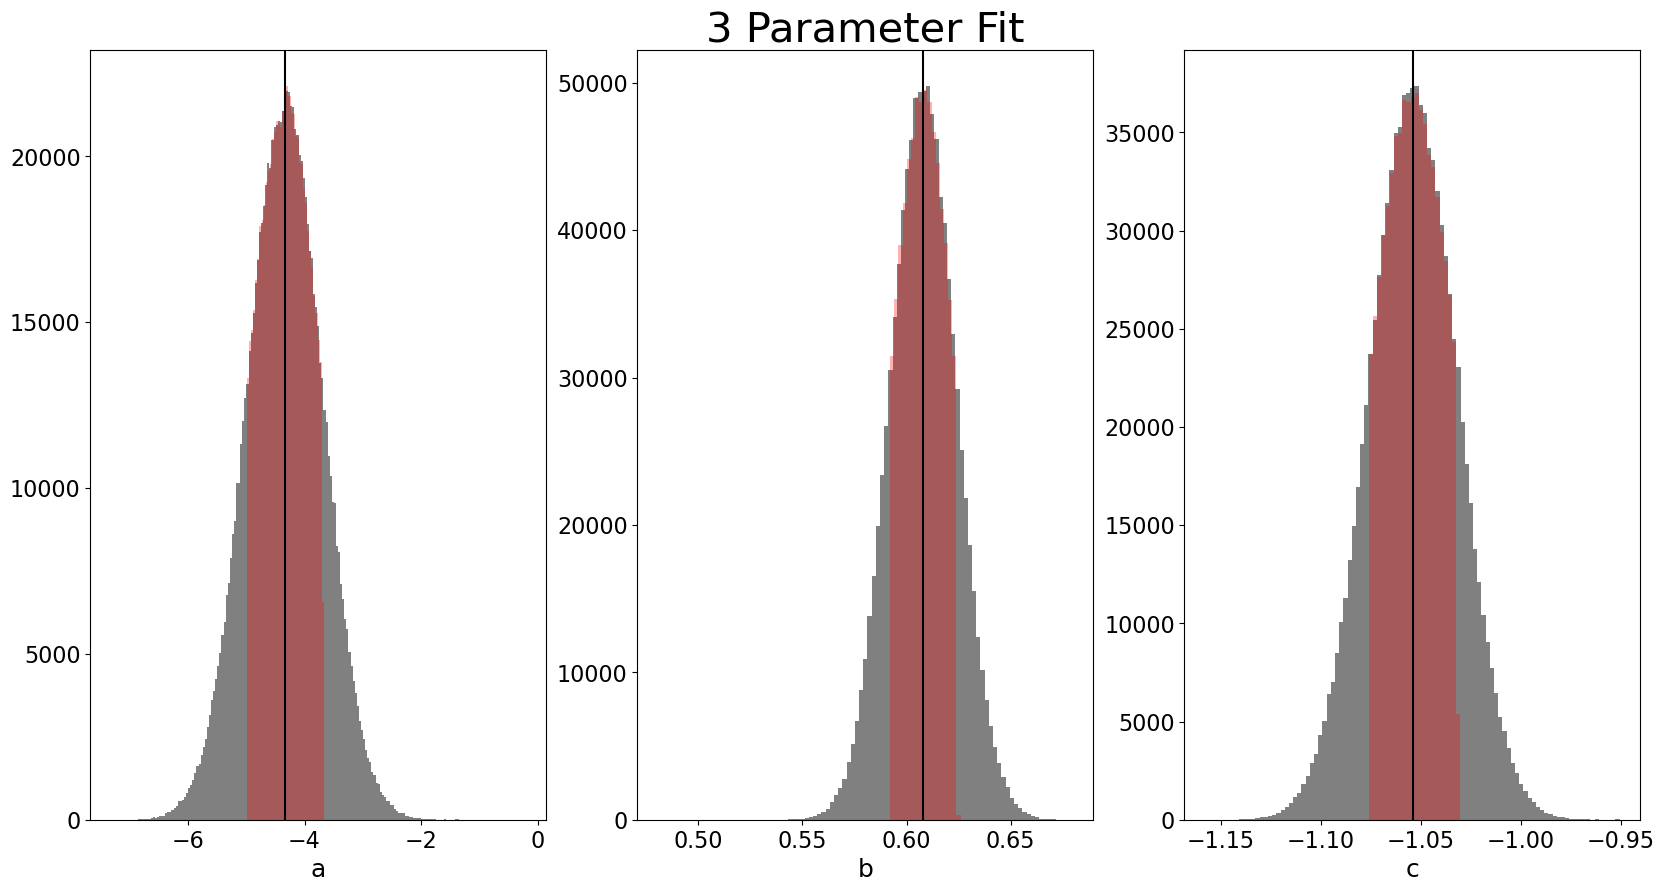

In [22]:
#plot histograms of each chain with confidence interval shaded

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

#bin the data from each chain and define the bin size 
bins1 = np.linspace(Tsamples[:, 0].min(),Tsamples[:, 0].max(),200)
bins2 = np.linspace(Tsamples[:, 1].min(),Tsamples[:, 1].max(),100)
bins3 = np.linspace(Tsamples[:, 2].min(),Tsamples[:, 2].max(),100)

binsize1 = (max(bins1)-min(bins1))/200
binsize2 = (max(bins2)-min(bins2))/100
binsize3 = (max(bins3)-min(bins3))/100

#plot full histograms overlaid by histograms of only 68% confidence interval shaded 
axes[0].hist(Tsamples[:, 0], bins=bins1, color='gray')
axes[0].hist(Tsamples1[start1:end1], bins=np.arange(Tsamples1[start1], Tsamples1[end1] + binsize1, binsize1),
             color='red', alpha=0.3)

axes[0].set_xlabel('a', fontsize = 18)
axes[0].axvline(a_fit, color='k')

axes[1].hist(Tsamples[:, 1], bins=bins2, color='gray')
axes[1].hist(Tsamples2[start2:end2], bins=np.arange(Tsamples2[start2], Tsamples2[end2] + binsize2, binsize2),
             color='red', alpha=0.3)

axes[1].set_xlabel('b', fontsize = 18)
axes[1].axvline(b_fit, color='k')

axes[2].hist(Tsamples[:, 2], bins=bins3, color='gray')
axes[2].hist(Tsamples3[start3:end3], bins=np.arange(Tsamples3[start3], Tsamples3[end3] + binsize3, binsize3),
             color='red', alpha=0.3)

axes[2].set_xlabel('c', fontsize = 18)
axes[2].axvline(c_fit, color='k')

axes[1].set_title('3 Parameter Fit', fontsize = 30)
#plt.savefig('histograms', bbox_inches = "tight",  pad_inches=0.2, transparent = True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1600x1600 with 0 Axes>

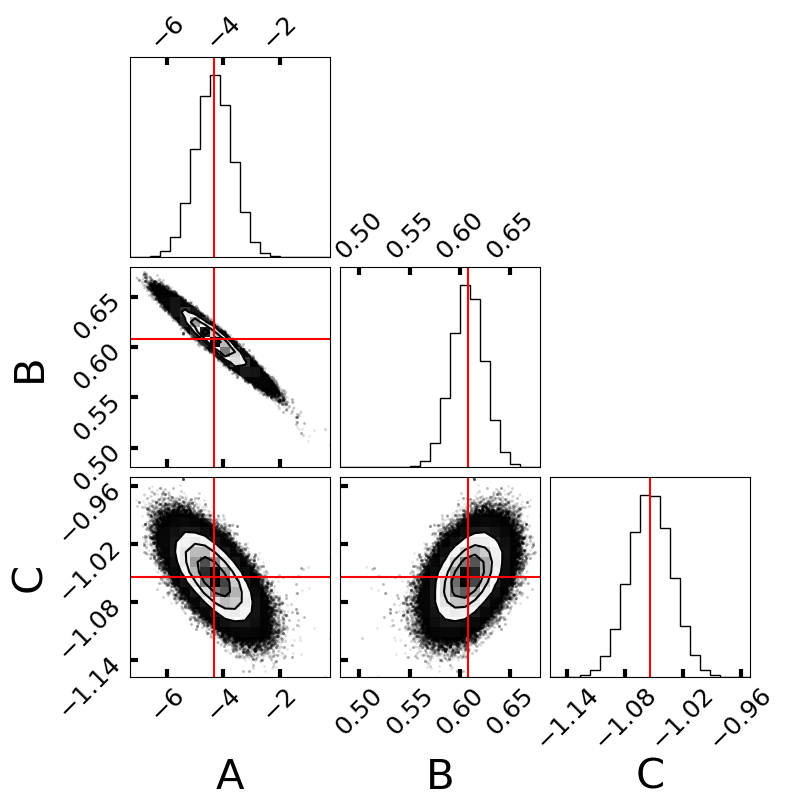

In [23]:
#create corner plot to show relationship between each chain
plt.figure(figsize=(16,16))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 3
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 3

#plt.tick_params(direction='in',length=10, width=4)
#plt.tick_params(direction='in',length=10, width=4)

truths=[mean1, mean2, mean3]

figure = corner.corner(Tsamples, labels=['A', 'B', 'C'], max_n_ticks= 4, labelpad = 0.1, top_ticks=True)

corner.overplot_lines(figure, truths, color="r")
plt.savefig('corner.eps', bbox_inches = "tight",  pad_inches=0.2, transparent = False, facecolor='white')
plt.show()

In [24]:
#print 16th, 50th, and 84th percentile values for each parameter given the MCMC chains

from IPython.display import display, Math

labels = ["a", "b", "c"]

fits_3param = np.zeros(3)
print("MCMC 50th Percentile")
for i in range(0,3):
    mcmc = np.percentile(Tsamples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    fits_3param[i] = mcmc[1]
    #print(mcmc, q)
    display(Math(txt))

MCMC 50th Percentile


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
#print the mean value and 50% confidence interval for each parameter given the MCMC chain

print("MCMC Sample Mean")
mcmc = np.array([conf_int_1[0], mean1, conf_int_1[1]])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
txt = txt.format(mcmc[1], q[0], q[1],'a')
display(Math(txt))

mcmc2 = np.array([conf_int_2[0], mean2, conf_int_2[1]])
q2 = np.diff(mcmc2)
txt2 = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
txt2 = txt2.format(mcmc2[1], q2[0], q2[1],'b')
display(Math(txt2))

mcmc3 = np.array([conf_int_3[0], mean3, conf_int_3[1]])
q3 = np.diff(mcmc3)
txt3 = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
txt3 = txt3.format(mcmc3[1], q3[0], q3[1],'c')
display(Math(txt3))

A = np.power(10, mean1)
eta = 3 * A / (10 * 0.03)

MCMC Sample Mean


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [26]:
#define empty arrays for each parameter 
Ta_vals = np.zeros(len(Tsamples[:,0]))
Tb_vals = np.zeros(len(Tsamples[:,0]))
Tc_vals = np.zeros(len(Tsamples[:,0]))

#loop over the entirety of each chain and populate the arrays only when all three parameter values are within
#their 68% confidence interval
j = 0
for i in range(0,len(Tsamples[:,0])):
    if Tsamples[i,0] > conf_int_1[0] and Tsamples[i,0] < conf_int_1[1]:
        if Tsamples[i,1] > conf_int_2[0] and Tsamples[i,1] < conf_int_2[1]:
            if Tsamples[i,2] > conf_int_3[0] and Tsamples[i,2] < conf_int_3[1]:
                Ta_vals[j] = Tsamples[i,0]
                Tb_vals[j] = Tsamples[i,1]
                Tc_vals[j] = Tsamples[i,2]
                j = j+1
print('done')

#%store Ta_vals
#%store Tb_vals
#%store V_cvals

done


In [27]:
#count number of nonzero values in new arrays
k = 0
for i in range(0,len(Ta_vals)):
    if Ta_vals[k] != 0:
        k = k+1
print(k)

#choose 500 random indices between 0 and k
values = np.random.randint(0, high=k, size = 500)

#create new empty array for calculated T0 values 
T0_values = np.zeros((11,len(values)))

#for each combination of mass and photosphere velocity (corresponding to energy = 1e51 erg), 
#calculate T0 given the combination (A,B,C) parameters
#at a random index in the the confidence interval arrays to populate the new caluclated T0 array

for m in range(0,11):
    for i in range(0,len(values)):
        j = values[i]
        T0_values[m,i] = mod_test(Ta_vals[j], Tb_vals[j], Tc_vals[j], Mej[m], V[m])

print('done')

474670
done


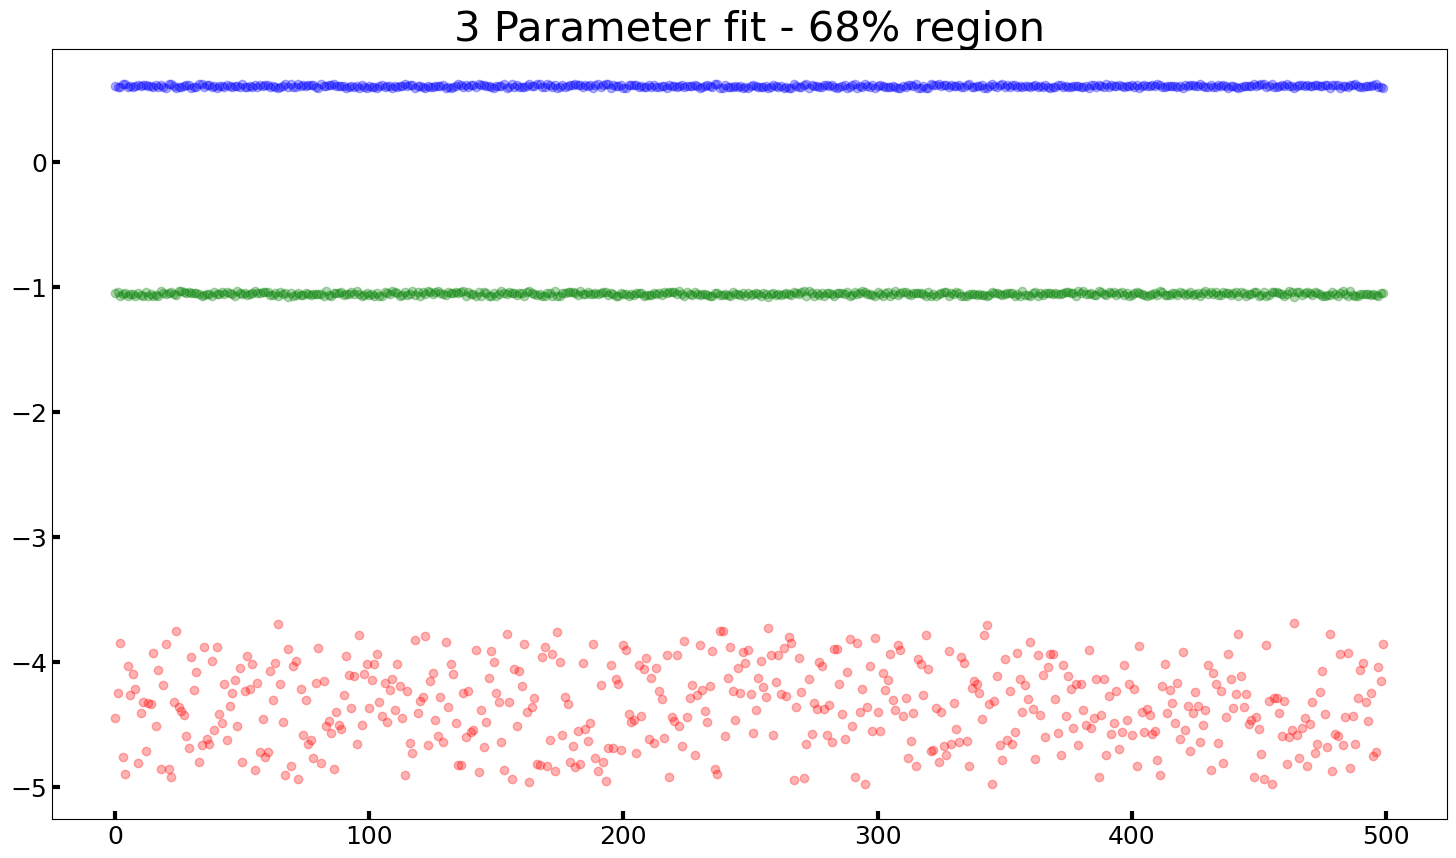

In [28]:
#plot the value of each parameter for each random index 

plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

plt.title('3 Parameter fit - 68% region', fontsize=30)
for i in range(0,len(values)):
        plt.scatter(i, Ta_vals[values[i]], c='r', alpha = 0.3)
        plt.scatter(i, Tb_vals[values[i]], c='b', alpha = 0.3)
        plt.scatter(i, Tc_vals[values[i]], c='g', alpha = 0.3)

-0.02503984546818309 0.4994483324123315


(0.5, 0.7)

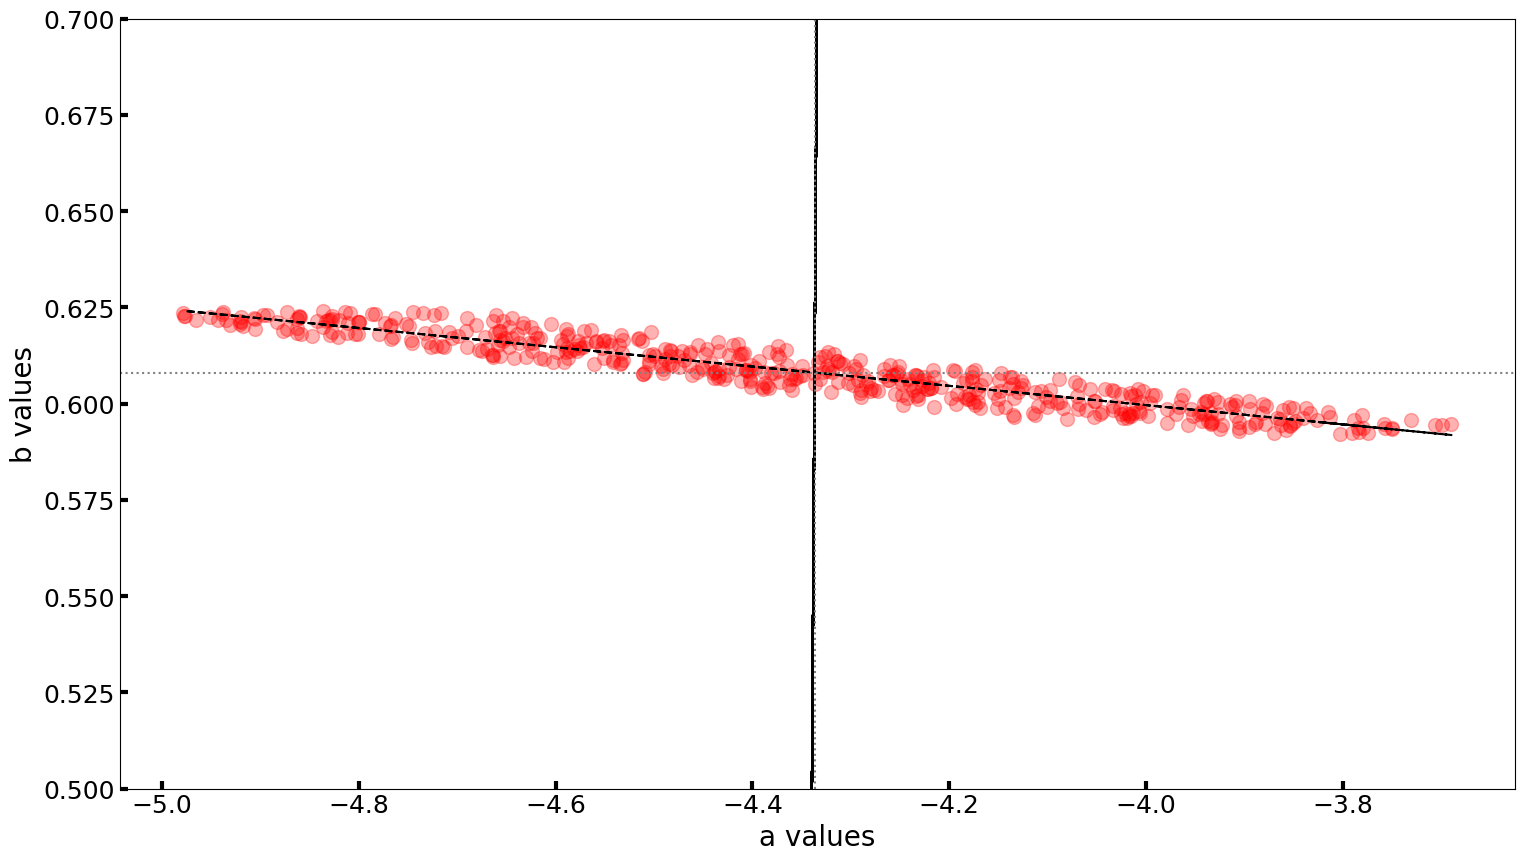

In [29]:
plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

#for each combination of (a, b , c) values in the random sample, calculate the ejecta mass 
#for a a given combination of measured T0 and energy 

#plot the b values vs the corresponding a values in the random sample, fill the scattered point solid if the
#calculated ejecta mass is within a 10% error of the true ejecta mass for that combination of T0 and energy

for i in range(0,len(values)):
    x = get_Mej(T0[45], E[45], Ta_vals[values[i]], Tb_vals[values[i]], V_cvals[values[i]])/Msun/M[45]
    if x < 1.1 and x > 0.9:
        plt.scatter(Ta_vals[values[i]], Tb_vals[values[i]], c='r', s=100)
        #plt.scatter(Ta_vals[values[i]], V_cvals[values[i]], c='b')
        
    else:
        plt.scatter(Ta_vals[values[i]], Tb_vals[values[i]], c='r', alpha=0.3, s=100)
        #plt.scatter(Ta_vals[values[i]], V_cvals[values[i]], c='b', alpha=0.3)

#calculate a polnomial fit to describe the relationship between a and b and plot the fit on top of the data   
y = np.polyfit(Ta_vals[0:500], Tb_vals[0:500], 1)
z = np.poly1d(y)
plt.plot(Ta_vals[0:500],z(Ta_vals[0:500]),"k--")
slope, intercept, r_value, p_value, std_err = stats.linregress(Ta_vals[0:500],z(Ta_vals[0:500]))
print(slope,intercept)

#plot the line perpendicular to the best fit 
b = mean2 + mean1/slope

plt.plot(Ta_vals[0:500], -Ta_vals[0:500]/slope + b, 'k--')

plt.axhline(mean2, c='gray', ls=':')
plt.axvline(mean1, c='gray', ls=':')

plt.xlabel('a values', fontsize=20)
plt.ylabel('b values', fontsize=20)
#plt.legend(fontsize=18)
#plt.xlim(-200, 200)
plt.ylim(0.5, 0.7)

0.0812468795748356 -0.6985558358817336
-54.4311977132236
-12.3081650056346 -54.4311977132236
-1.0


(-2.0, 0.0)

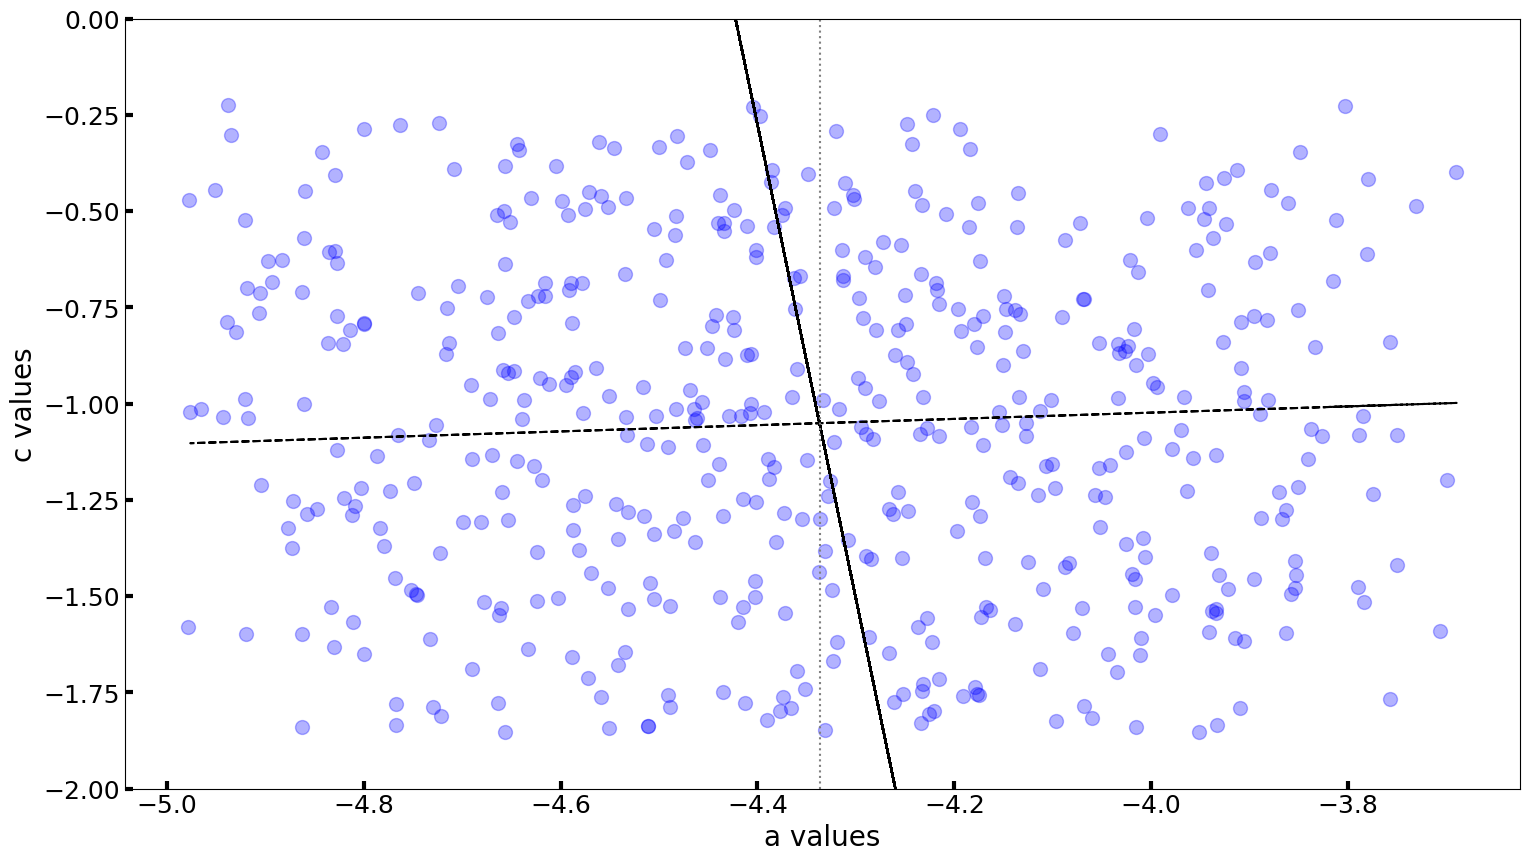

In [30]:
# repeat above for a and c values 

plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

for i in range(0,len(values)):
    x = get_Mej(T0[45], E[45], Ta_vals[values[i]], Tb_vals[values[i]], V_cvals[values[i]])/Msun/M[45]
    if x < 1.1 and x > 0.9:
        plt.scatter(Ta_vals[values[i]], V_cvals[values[i]], c='b', s=100)
        
    else:
        plt.scatter(Ta_vals[values[i]], V_cvals[values[i]], c='b', alpha=0.3, s=100)
        

y = np.polyfit(Ta_vals[0:500], V_cvals[0:500], 1)
z = np.poly1d(y)
plt.plot(Ta_vals[0:500],z(Ta_vals[0:500]),"k--")

slope, intercept, r_value, p_value, std_err = stats.linregress(Ta_vals[0:500],z(Ta_vals[0:500]))
print(slope,intercept)

b = mean3 + mean1/slope
print(b)

plt.plot(Ta_vals[0:500], -Ta_vals[0:500]/slope + b, 'k--')

slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(Ta_vals[0:500], -Ta_vals[0:500]/slope + b)

print(slope2, intercept2)

print(slope*slope2)

plt.axhline(mean2, c='gray', ls=':')
plt.axvline(mean1, c='gray', ls=':')
        
plt.xlabel('a values', fontsize=20)
plt.ylabel('c values', fontsize=20)
#plt.legend(fontsize=18)
#plt.xlim(-200,200)
plt.ylim(-2,0)

Text(0, 0.5, 'c values')

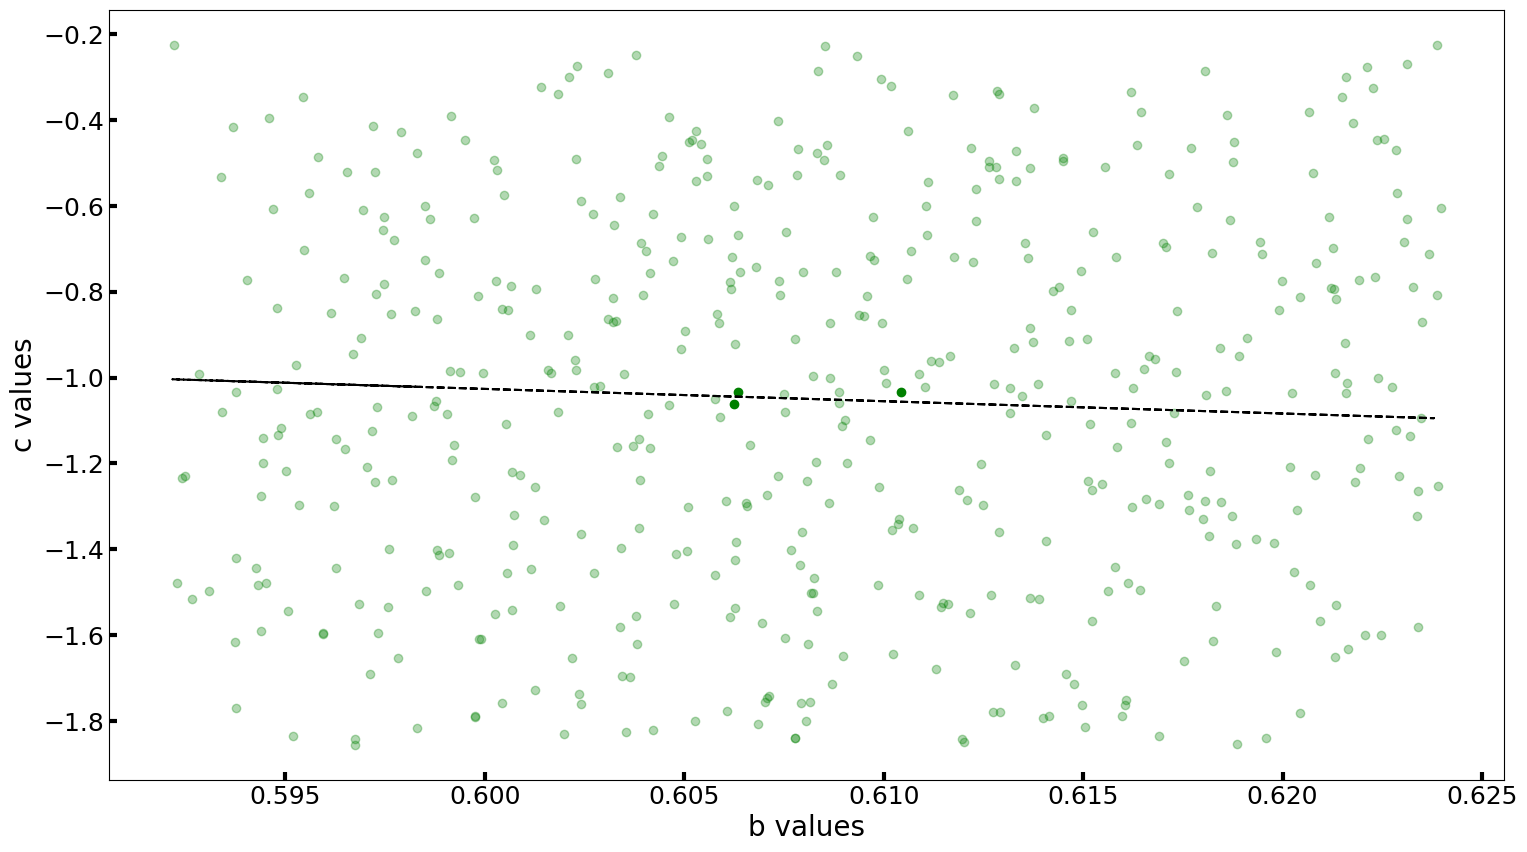

In [31]:
## repeat above for b and c values 
plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

for i in range(0,len(values)):
    x = get_Mej(T0[45], V[45], Ta_vals[values[i]], Tb_vals[values[i]], V_cvals[values[i]])/Msun/M[45]
    if x < 1.1 and x > 0.9:
        plt.scatter(Tb_vals[values[i]], V_cvals[values[i]], c='g')
        
    else:
        plt.scatter(Tb_vals[values[i]], V_cvals[values[i]], c='g', alpha=0.3)
        
y = np.polyfit(Tb_vals[0:500], V_cvals[0:500], 1)
z = np.poly1d(y)
plt.plot(Tb_vals[0:500],z(Tb_vals[0:500]),"k--")
        
plt.xlabel('b values', fontsize=20)
plt.ylabel('c values', fontsize=20)

Text(0.5, 0.9, 'E = 1e+51 ${\\rm erg}$')

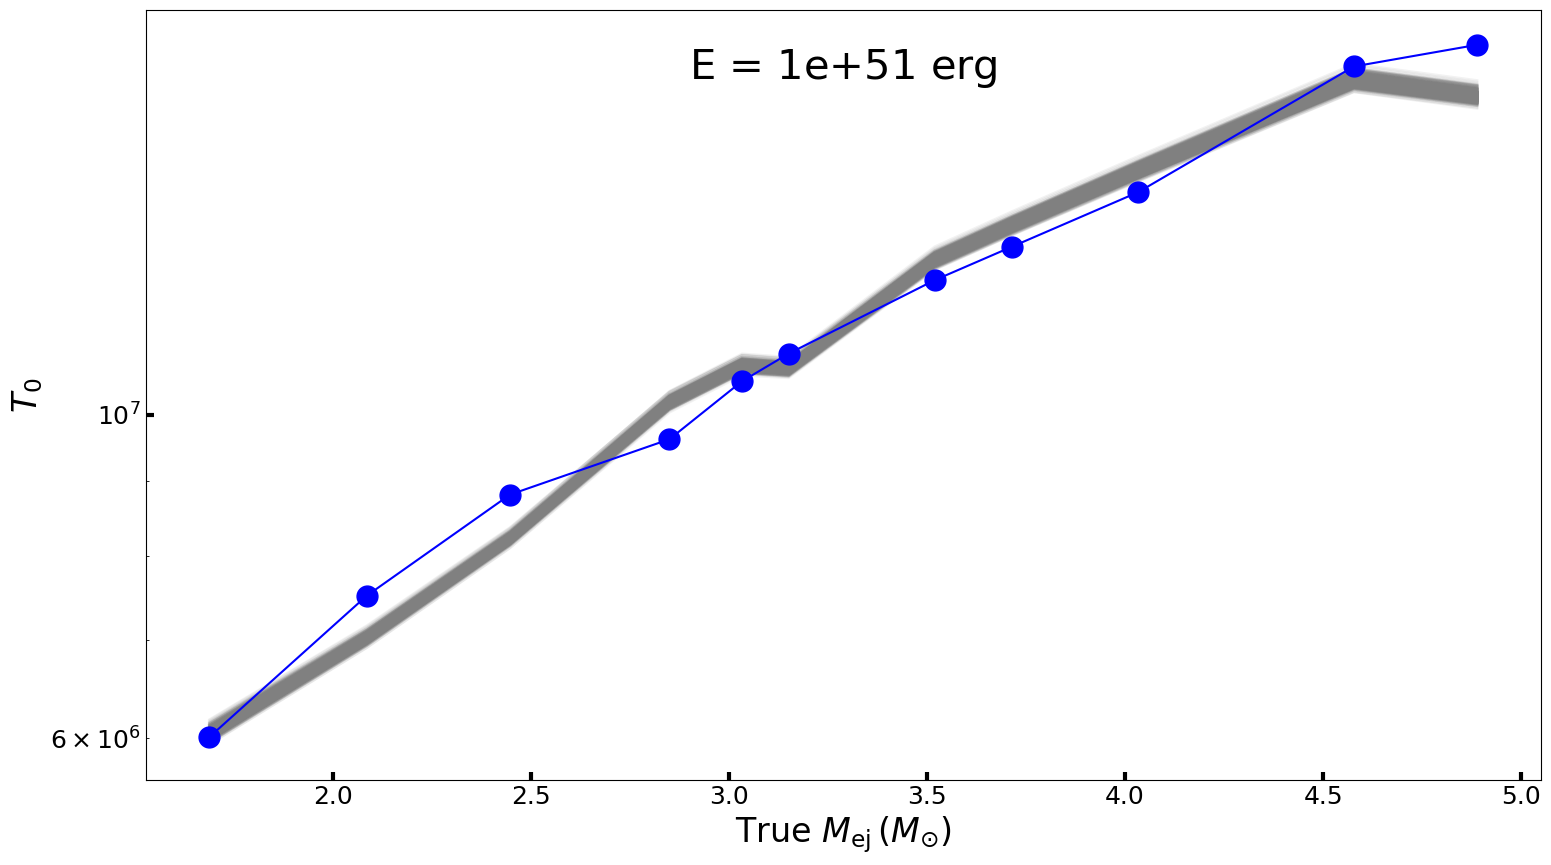

In [32]:
i = 0

plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

#define a subset of true ejecta masses and their corresponding measured T0 values for a given energy
j = i*11
Mej_ = np.array([Mej[0], Mej[1], Mej[2], Mej[3], Mej[4], Mej[5], Mej[6], Mej[7], Mej[8], Mej[9], Mej[10]])
T0_ = np.array([T0[j], T0[j+1], T0[j+2], T0[j+3], T0[j+4], T0[j+5], T0[j+6], T0[j+7], T0[j+8],
                    T0[j+9], T0[j+10]])

#print the 500 T0 values calculated from the random set of (a,b,c) values vs ejecta mass
for k in range(0,len(values)):
    plt.plot(Mej_, T0_values[:,k], 'gray', alpha = 0.1)

#pring the measured T0 values vs true ejecta mass 
plt.plot(Mej, T0_, c='b', marker='o', ms=15)

plt.xlabel(r'True $M_{\rm ej} \,(M_{\odot}$)', fontsize=24)
plt.ylabel(r'$T_0$', fontsize=24)
#plt.xscale('log')
plt.yscale('log')
plt.title(r"E = %lg ${\rm erg}$" %En[i], fontsize=30, x= 0.5, y=0.9)
#plt.savefig('3param_fit', bbox_inches = "tight",  pad_inches=0.5, transparent = False, facecolor='white')

## Apply best fit (a,b,c) to simulation data

In [33]:
#calculate T0 values for each combination of ejecta mass and energy given the 50th percentile values of (a,b,c)
T0_calc = np.power(10,model(fits_3param[0], fits_3param[1], fits_3param[2]))

(1.5, 5.133660000000001)

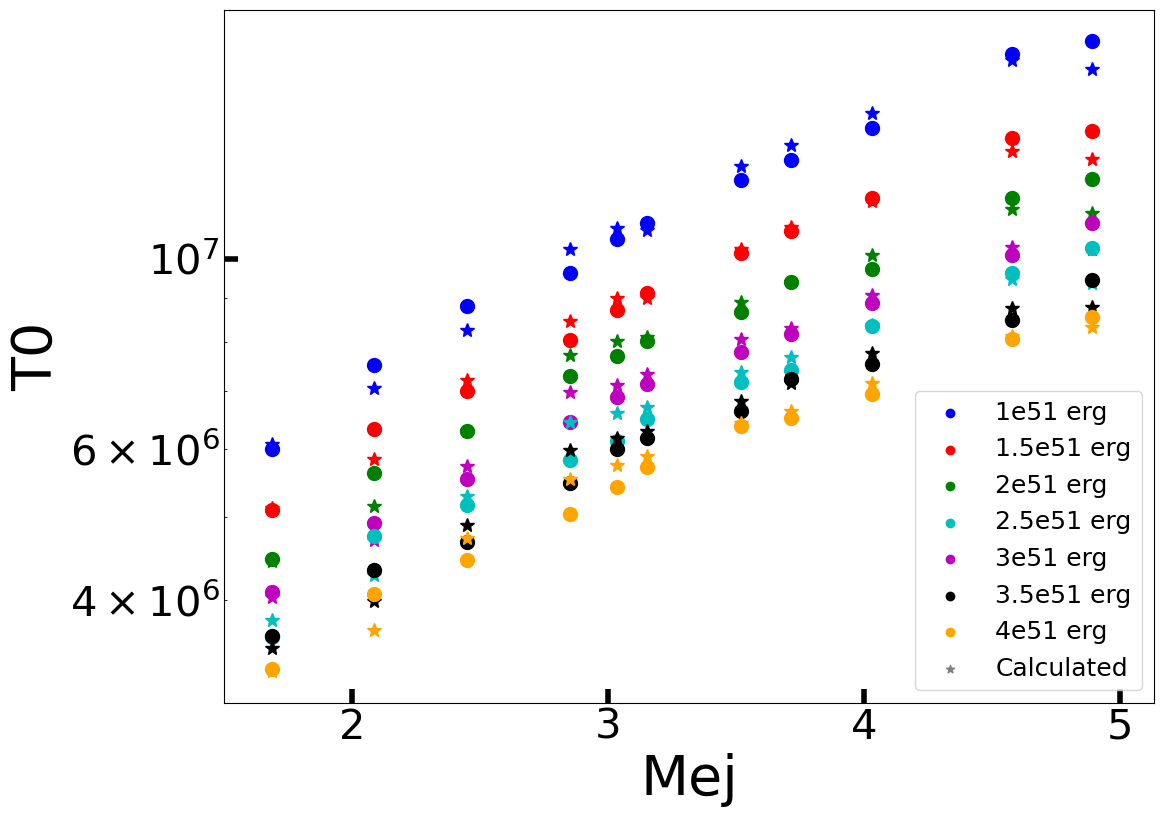

In [34]:
#plot measured T0 and calculated T0 vs ejecta mass 

plt.figure(figsize=(12,9))
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
plt.tick_params(direction='in',length=10, width=4)
plt.tick_params(direction='in',length=10, width=4)

for i in range(0,7):
    plt.plot(M[i*11:(i*11)+11], T0[i*11:(i*11)+11], c=color[i], marker='o', ls='', ms=10)
    plt.plot(M[i*11:(i*11)+11], T0_calc[i*11:(i*11)+11], c=color[i], marker='*', ls='', ms=10)
    
a = np.zeros(3)
plt.scatter(a, a, c='b', label = '1e51 erg')
plt.scatter(a, a, c='r', label = '1.5e51 erg')
plt.scatter(a, a, c='g', label = '2e51 erg')
plt.scatter(a, a, c='c', label = '2.5e51 erg')
plt.scatter(a, a, c='m', label = '3e51 erg')
plt.scatter(a, a, c='k', label = '3.5e51 erg')
plt.scatter(a, a, c='orange', label = '4e51 erg')
plt.scatter(a, a, c='gray', marker='*', label = 'Calculated')
plt.legend(fontsize=18)
    
plt.xlabel('Mej', fontsize=40)
plt.ylabel('T0', fontsize=40)
plt.yscale('log')
plt.xlim(1.5)

In [35]:
#define new variable such that a_fit = log10(A_prime)
A_prime = np.power(10, a_fit)

In [36]:
#Calculate ejecta masses given the measued T0 and photospheric velocity values using varous combinations of 
#(a,b,c) fits

M_calc = get_Mej(T0, V, fits_3param[0], fits_3param[1], fits_3param[2])/Msun #MCMC 50th percentile
M_calc4 = get_Mej(T0, V, a_fit, b_fit, c_fit)/Msun #scipy optimized 
M_calc5 = get_Mej(T0, V, mean1, mean2, mean3)/Msun #MCMC mean values 
M_calc6 = get_Mej(T0, V, -1.151, 0.5, -1.0)/Msun #Wheeler et al. 2015 values
M_calc7 = get_Mej(T0, V, -4.009,  0.5747, -0.9667)/Msun #50th percentile (a,b,c) values from fitting
#T0 over shorter time frame (100 days vs 200days)


#as above, calculate ejecta masses for various test cases including increased Nickel 56 mixing or concentration

#MCMC 50th percentile
M_mix = get_Mej(T0_mix*day, V[0:11], fits_3param[0], fits_3param[1], fits_3param[2])/Msun
M_nickel = get_Mej(T0_high_nickel*day, V[0:11], fits_3param[0], fits_3param[1], fits_3param[2])/Msun

#scipy optimized
M_mix4 = get_Mej(T0_mix*day, V[0:11], a_fit, b_fit, c_fit)/Msun
M_nickel4 = get_Mej(T0_high_nickel*day, V[0:11], a_fit, b_fit, c_fit)/Msun

#MCMC mean values
M_mix5 = get_Mej(T0_mix*day, V[0:11], mean1, mean2, mean3)/Msun
M_nickel5 = get_Mej(T0_high_nickel*day, V[0:11], mean1, mean2, mean3)/Msun

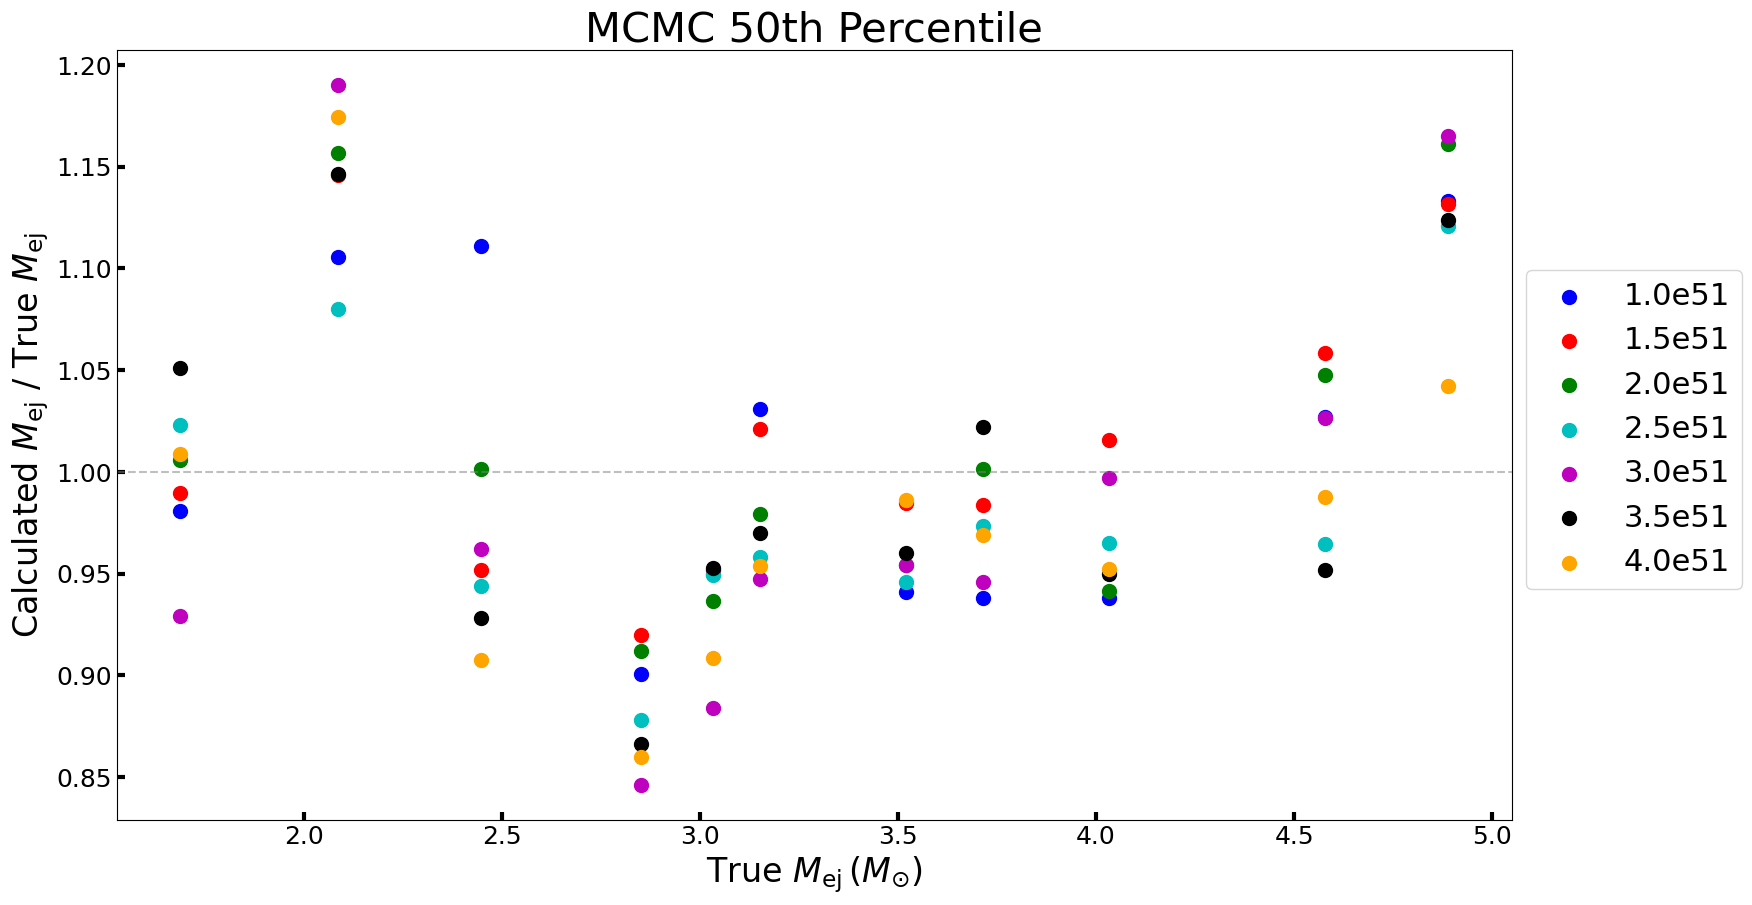

In [37]:
#plot the ratio of the calculated ejecta masses to true ejecta mass for each energy using 50th percentile (a,b,c)

plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

plt.scatter(M[0:11], M_calc[0:11]/M[0:11], c='b', s=100, label = '1.0e51')
plt.scatter(M[11:22], M_calc[11:22]/M[11:22], c='r', s=100, label = '1.5e51')
plt.scatter(M[22:33], M_calc[22:33]/M[22:33], c='g', s=100, label = '2.0e51')
plt.scatter(M[33:44], M_calc[33:44]/M[33:44], c='c', s=100, label = '2.5e51')
plt.scatter(M[44:55], M_calc[44:55]/M[44:55], c='m', s=100, label = '3.0e51')
plt.scatter(M[55:66], M_calc[55:66]/M[55:66], c='k', s=100, label = '3.5e51')
plt.scatter(M[66:77], M_calc[66:77]/M[66:77], c='orange', s=100, label = '4.0e51')


plt.axhline(1, c='gray', ls = '--', alpha = 0.5)

plt.xlabel(r'True $M_{\rm ej} \,(M_{\odot}$)', fontsize=24)
plt.ylabel(r'Calculated $M_{\rm ej}$ / True $M_{\rm ej}$', fontsize=24)
plt.title('MCMC 50th Percentile', fontsize=30)
plt.legend(loc = (1.01, 0.3), fontsize=22)
#plt.savefig('3param_fit', bbox_inches = "tight",  pad_inches=0.5, transparent = True)

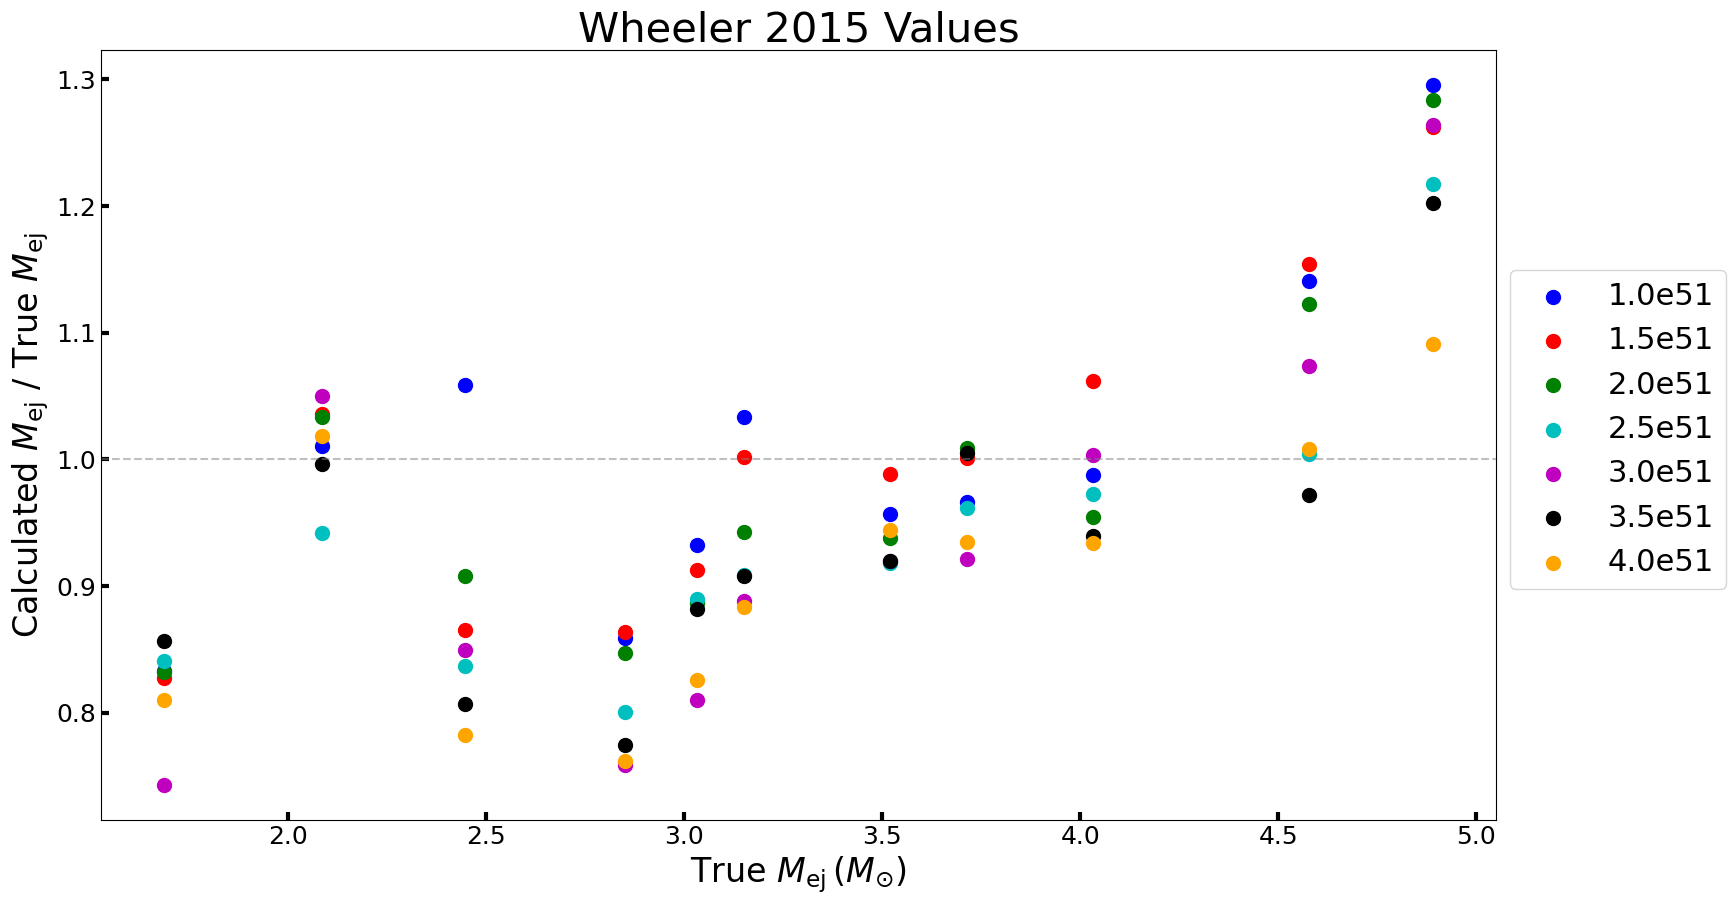

In [38]:
#plot the ratio of the calculated ejecta masses to true ejecta mass for each energy using Wheeler 2015 (a,b,c)

plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

plt.scatter(M[0:11], M_calc6[0:11]/M[0:11], c='b', s=100, label = '1.0e51')
plt.scatter(M[11:22], M_calc6[11:22]/M[11:22], c='r', s=100, label = '1.5e51')
plt.scatter(M[22:33], M_calc6[22:33]/M[22:33], c='g', s=100, label = '2.0e51')
plt.scatter(M[33:44], M_calc6[33:44]/M[33:44], c='c', s=100, label = '2.5e51')
plt.scatter(M[44:55], M_calc6[44:55]/M[44:55], c='m', s=100, label = '3.0e51')
plt.scatter(M[55:66], M_calc6[55:66]/M[55:66], c='k', s=100, label = '3.5e51')
plt.scatter(M[66:77], M_calc6[66:77]/M[66:77], c='orange', s=100, label = '4.0e51')


plt.axhline(1, c='gray', ls = '--', alpha = 0.5)

plt.xlabel(r'True $M_{\rm ej} \,(M_{\odot}$)', fontsize=24)
plt.ylabel(r'Calculated $M_{\rm ej}$ / True $M_{\rm ej}$', fontsize=24)
plt.title('Wheeler 2015 Values', fontsize=30)
plt.legend(loc = (1.01, 0.3), fontsize=22)
#plt.savefig('3param_fit', bbox_inches = "tight",  pad_inches=0.5, transparent = True)

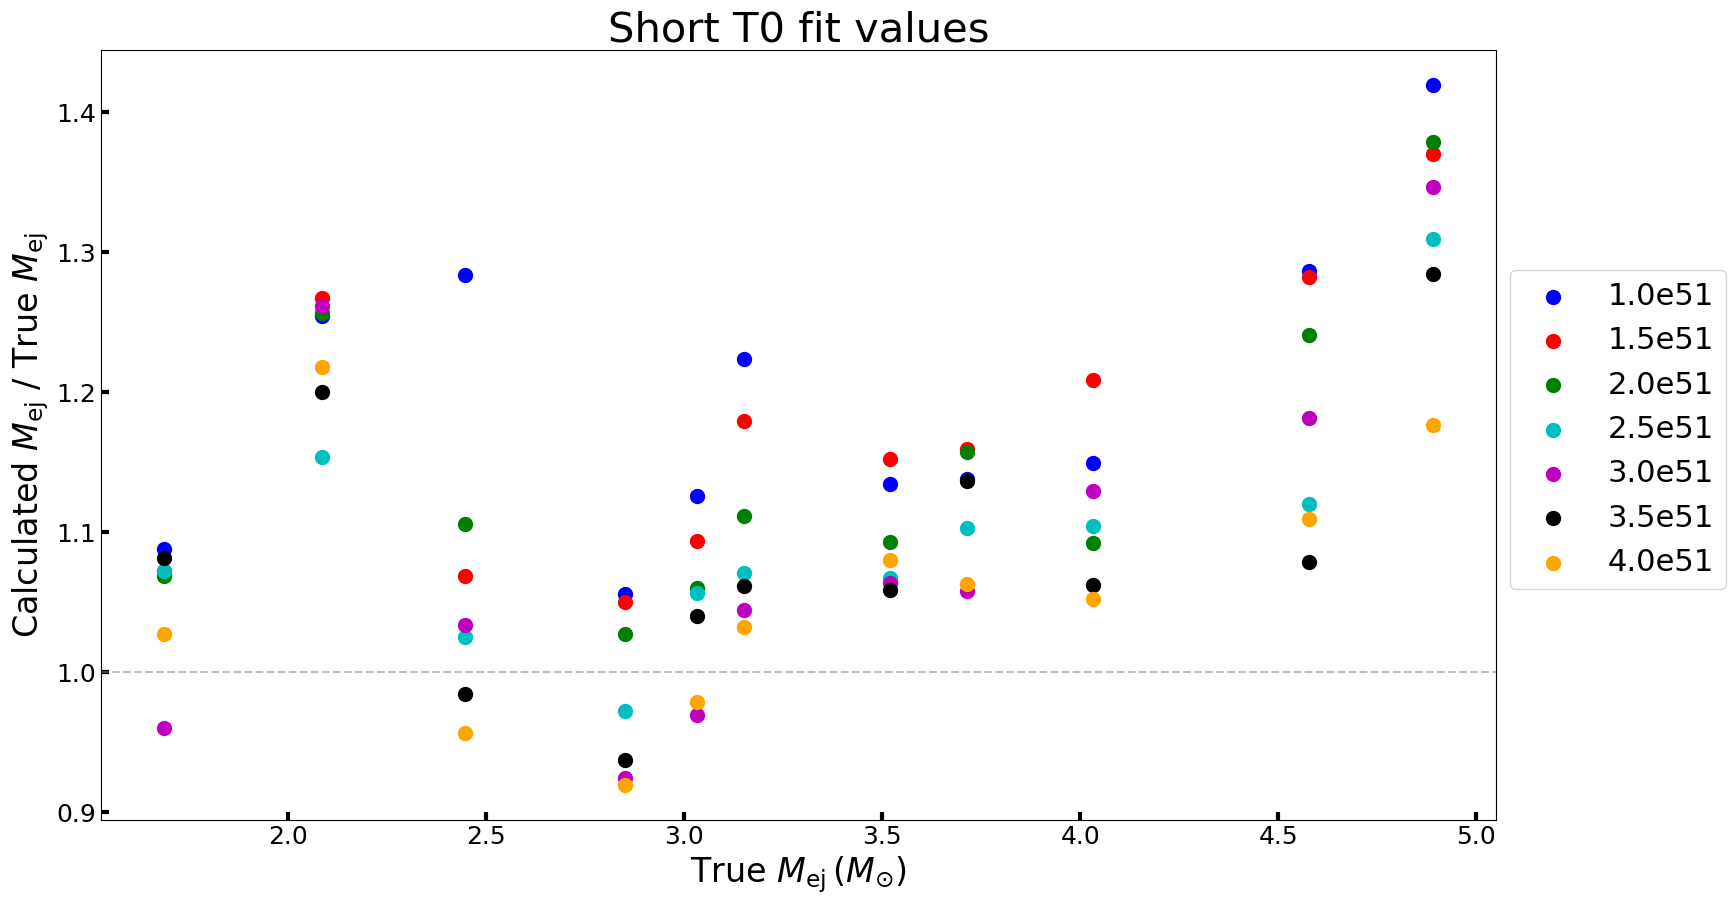

In [39]:
#plot the ratio of the calculated ejecta masses to true ejecta mass for each energy using 100 day T0 fit (a,b,c)
plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

plt.scatter(M[0:11], M_calc7[0:11]/M[0:11], c='b', s=100, label = '1.0e51')
plt.scatter(M[11:22], M_calc7[11:22]/M[11:22], c='r', s=100, label = '1.5e51')
plt.scatter(M[22:33], M_calc7[22:33]/M[22:33], c='g', s=100, label = '2.0e51')
plt.scatter(M[33:44], M_calc7[33:44]/M[33:44], c='c', s=100, label = '2.5e51')
plt.scatter(M[44:55], M_calc7[44:55]/M[44:55], c='m', s=100, label = '3.0e51')
plt.scatter(M[55:66], M_calc7[55:66]/M[55:66], c='k', s=100, label = '3.5e51')
plt.scatter(M[66:77], M_calc7[66:77]/M[66:77], c='orange', s=100, label = '4.0e51')


plt.axhline(1, c='gray', ls = '--', alpha = 0.5)

plt.xlabel(r'True $M_{\rm ej} \,(M_{\odot}$)', fontsize=24)
plt.ylabel(r'Calculated $M_{\rm ej}$ / True $M_{\rm ej}$', fontsize=24)
plt.title('Short T0 fit values', fontsize=30)
plt.legend(loc = (1.01, 0.3), fontsize=22)
#plt.savefig('3param_fit', bbox_inches = "tight",  pad_inches=0.5, transparent = True)

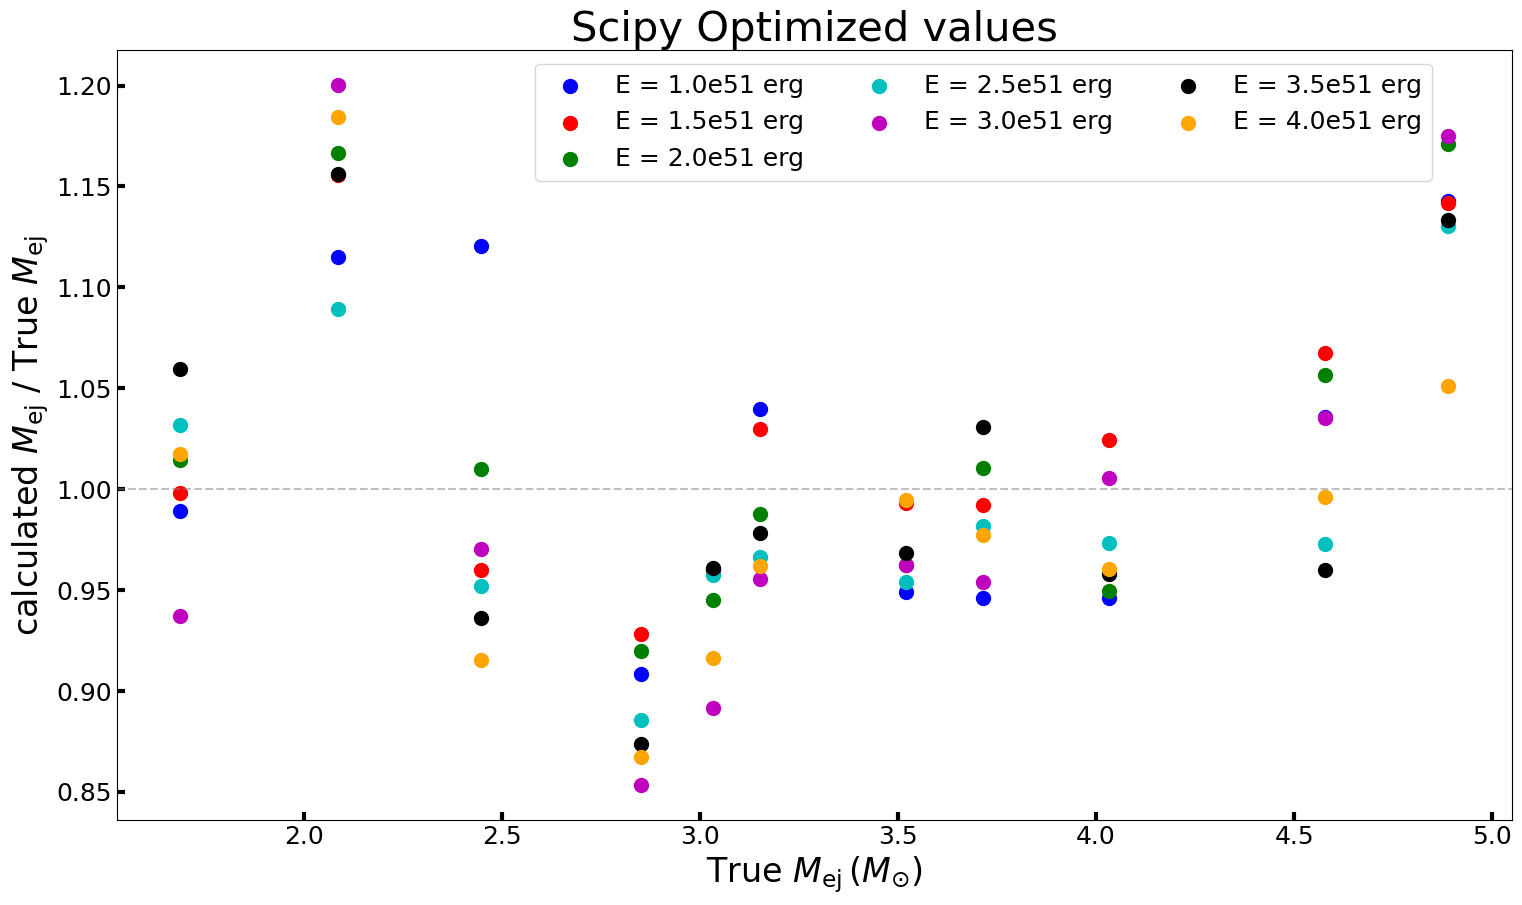

In [40]:
#plot the ratio of the calculated ejecta masses to true ejecta mass for each energy using scipy optimized (a,b,c)
plt.figure(figsize=(18,10))
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

plt.scatter(M[0:11], M_calc4[0:11]/M[0:11], c='b', s=100, label = 'E = 1.0e51 erg')
plt.scatter(M[11:22], M_calc4[11:22]/M[11:22], c='r', s=100, label = 'E = 1.5e51 erg')
plt.scatter(M[22:33], M_calc4[22:33]/M[22:33], c='g', s=100, label = 'E = 2.0e51 erg')
plt.scatter(M[33:44], M_calc4[33:44]/M[33:44], c='c', s=100, label = 'E = 2.5e51 erg')
plt.scatter(M[44:55], M_calc4[44:55]/M[44:55], c='m', s=100, label = 'E = 3.0e51 erg')
plt.scatter(M[55:66], M_calc4[55:66]/M[55:66], c='k', s=100, label = 'E = 3.5e51 erg')
plt.scatter(M[66:77], M_calc4[66:77]/M[66:77], c='orange', s=100, label = 'E = 4.0e51 erg')

plt.axhline(1, c='gray', ls = '--', alpha = 0.5)

plt.xlabel(r'True $M_{\rm ej} \,(M_{\odot}$)', fontsize=24)
plt.ylabel(r'calculated $M_{\rm ej}$ / True $M_{\rm ej}$', fontsize=24)
plt.title('Scipy Optimized values', fontsize=30)
plt.legend(loc = (0.3, 0.83), fontsize=18, ncol=3)
#plt.savefig('3param_fit_op.eps', bbox_inches = "tight",  pad_inches=0.5, transparent = True, facecolor='white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


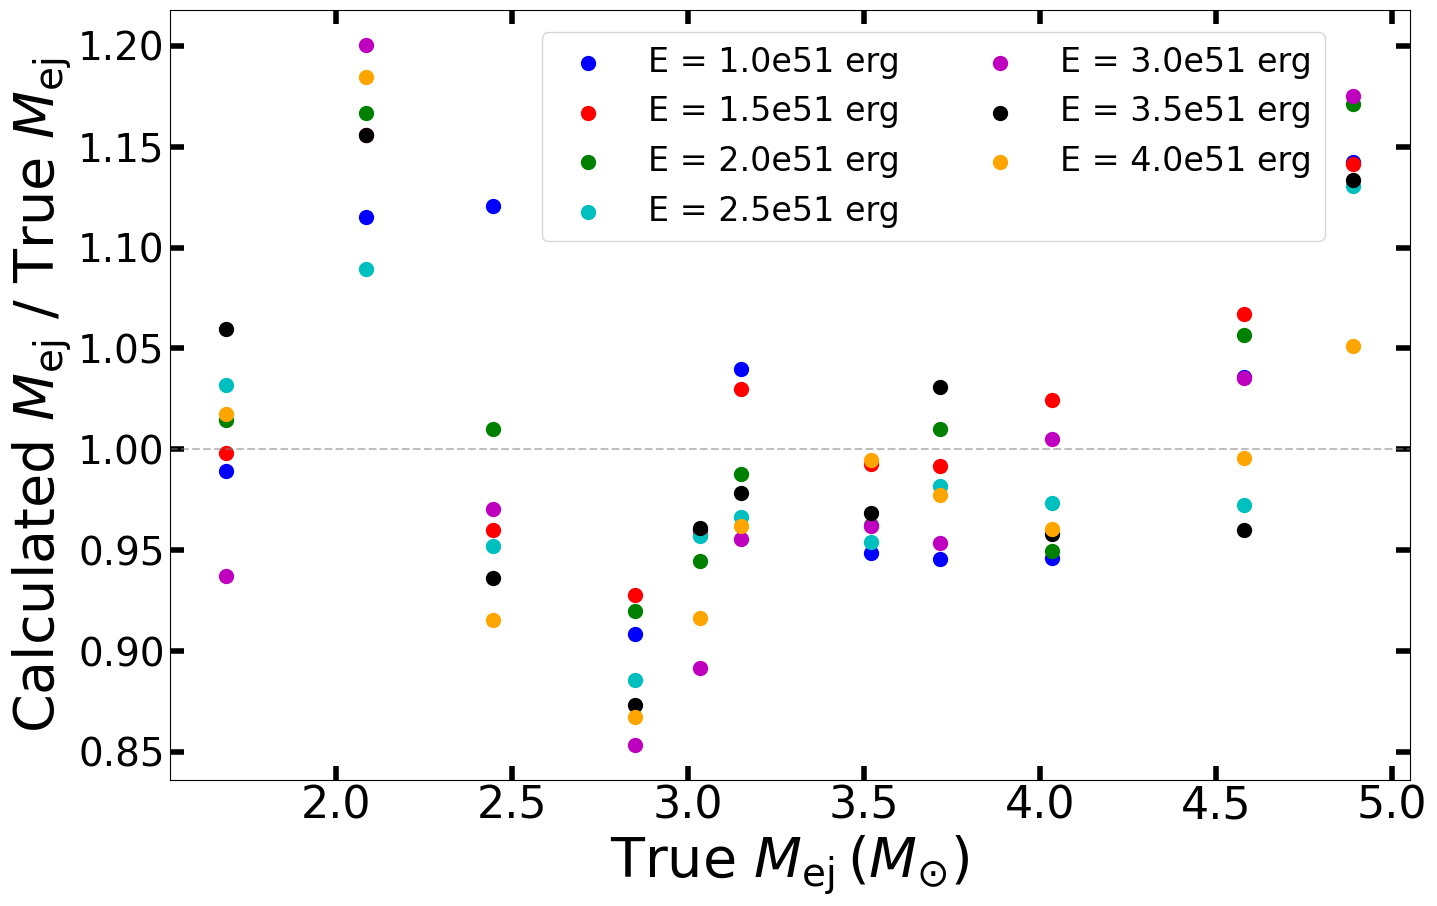

In [41]:
#plot the ratio of the calculated ejecta masses to true ejecta mass for each energy using MCMC mean (a,b,c)

plt.figure(figsize=(16,10))
matplotlib.rcParams['xtick.labelsize'] = 32
matplotlib.rcParams['ytick.labelsize'] = 28
plt.tick_params(direction='in',length=10, width=4, top = True, right = True)

plt.scatter(M[0:11], M_calc5[0:11]/M[0:11], c='b', s=100, label = 'E = 1.0e51 erg')
plt.scatter(M[11:22], M_calc5[11:22]/M[11:22], c='r', s=100, label = 'E = 1.5e51 erg')
plt.scatter(M[22:33], M_calc5[22:33]/M[22:33], c='g', s=100, label = 'E = 2.0e51 erg')
plt.scatter(M[33:44], M_calc5[33:44]/M[33:44], c='c', s=100, label = 'E = 2.5e51 erg')
plt.scatter(M[44:55], M_calc5[44:55]/M[44:55], c='m', s=100, label = 'E = 3.0e51 erg')
plt.scatter(M[55:66], M_calc5[55:66]/M[55:66], c='k', s=100, label = 'E = 3.5e51 erg')
plt.scatter(M[66:77], M_calc5[66:77]/M[66:77], c='orange', s=100, label = 'E = 4.0e51 erg')

plt.axhline(1, c='gray', ls = '--', alpha = 0.5)

plt.xlabel(r'True $M_{\rm ej} \,(M_{\odot}$)', fontsize=40)
plt.ylabel(r'Calculated $M_{\rm ej}$ / True $M_{\rm ej}$', fontsize=40)
#plt.title('3 Parameter Fit - MCMC Sample Means', fontsize=30)
plt.legend(loc = (0.3, 0.7), fontsize=24, ncol=2)
plt.savefig('3param_fit_mean.eps', bbox_inches = "tight",  pad_inches=0.2, transparent = True, facecolor='white')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


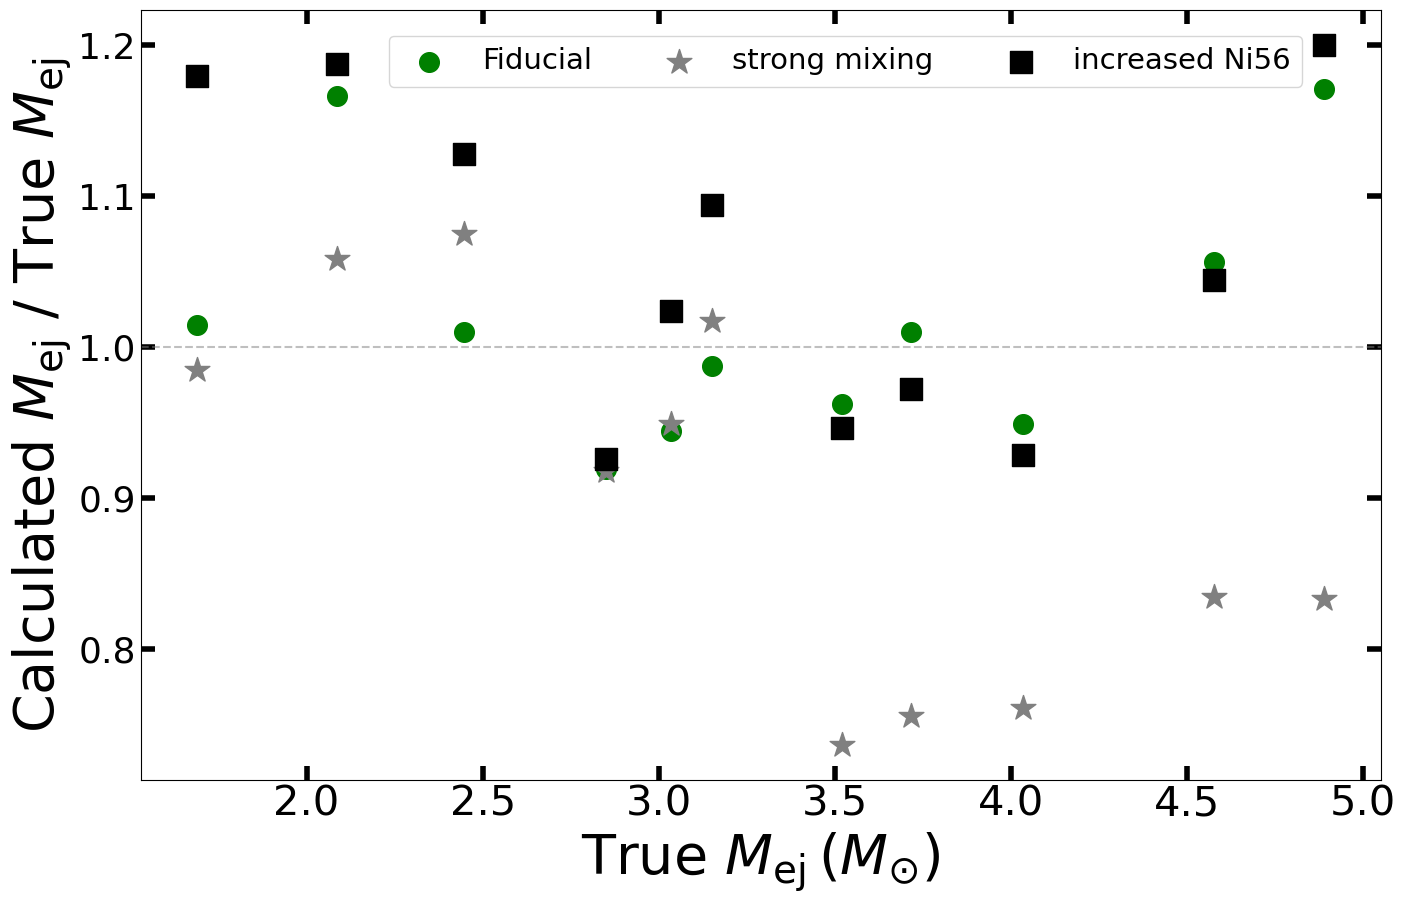

In [42]:
#plot the ratio of the calculated ejecta masses to true ejecta mass for each 
#test case using MCMC mean (a,b,c)

plt.figure(figsize=(16,10))
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 26
plt.tick_params(direction='in',length=10, width=4, top = True, right = True)

plt.scatter(M[22:33], M_calc5[22:33]/M[22:33], c='g', s=200, label = 'Fiducial')
plt.scatter(M[22:33], M_mix5/M[22:33], c='gray', marker='*', s=350, label = 'strong mixing')
plt.scatter(M[22:33], M_nickel5/M[22:33], c='k', marker='s', s=250, label = 'increased Ni56')


plt.axhline(1, c='gray', ls = '--', alpha = 0.5)

plt.xlabel(r'True $M_{\rm ej} \,(M_{\odot}$)', fontsize=40)
plt.ylabel(r'Calculated $M_{\rm ej}$ / True $M_{\rm ej}$', fontsize=40)
#plt.title('3 Parameter Fit - MCMC Mean', fontsize=30)
plt.legend(loc = (0.2, 0.9), fontsize=21, ncol=3)
plt.savefig('other_fit.eps', bbox_inches = "tight",  pad_inches=0.2, transparent = True, facecolor='White')